<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

### General look at data. 

In [4]:
print house.shape

(1460, 81)


In [5]:
# drop Id because it does provide any significant information to describe SalePrice
house = house.drop('Id',axis=1)

In [6]:
print len(house.columns)
house.columns

80


Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageCars'

In [7]:
numeric = house.select_dtypes(exclude=['object']).columns
print len(numeric)
print numeric

37
Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')


In [8]:
categorical = house.select_dtypes(include=['object']).columns
print len(categorical)
print categorical

43
Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')


In [9]:
renov_col = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
             'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
             'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

print len(renov_col)
print renov_col

21
['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']


In [10]:
fixed = [c for c in house.columns if c not in renov_col]
print len(fixed)
print fixed

59
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']


In [11]:
house['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [12]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

### Remove non residential rows. Store target variable as 'SalePrice'

In [13]:
# Extract Target
target = house['SalePrice']

# Remove non residential rows
data = house.drop(house[house.MSZoning == 'C (all)'].index, axis = 0)

data.shape

(1450, 80)

### Examine 'SalePrice'

In [14]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### SalePrice values are huge and range is over 20 times between min and max
#### Slight right skewed (positive) 

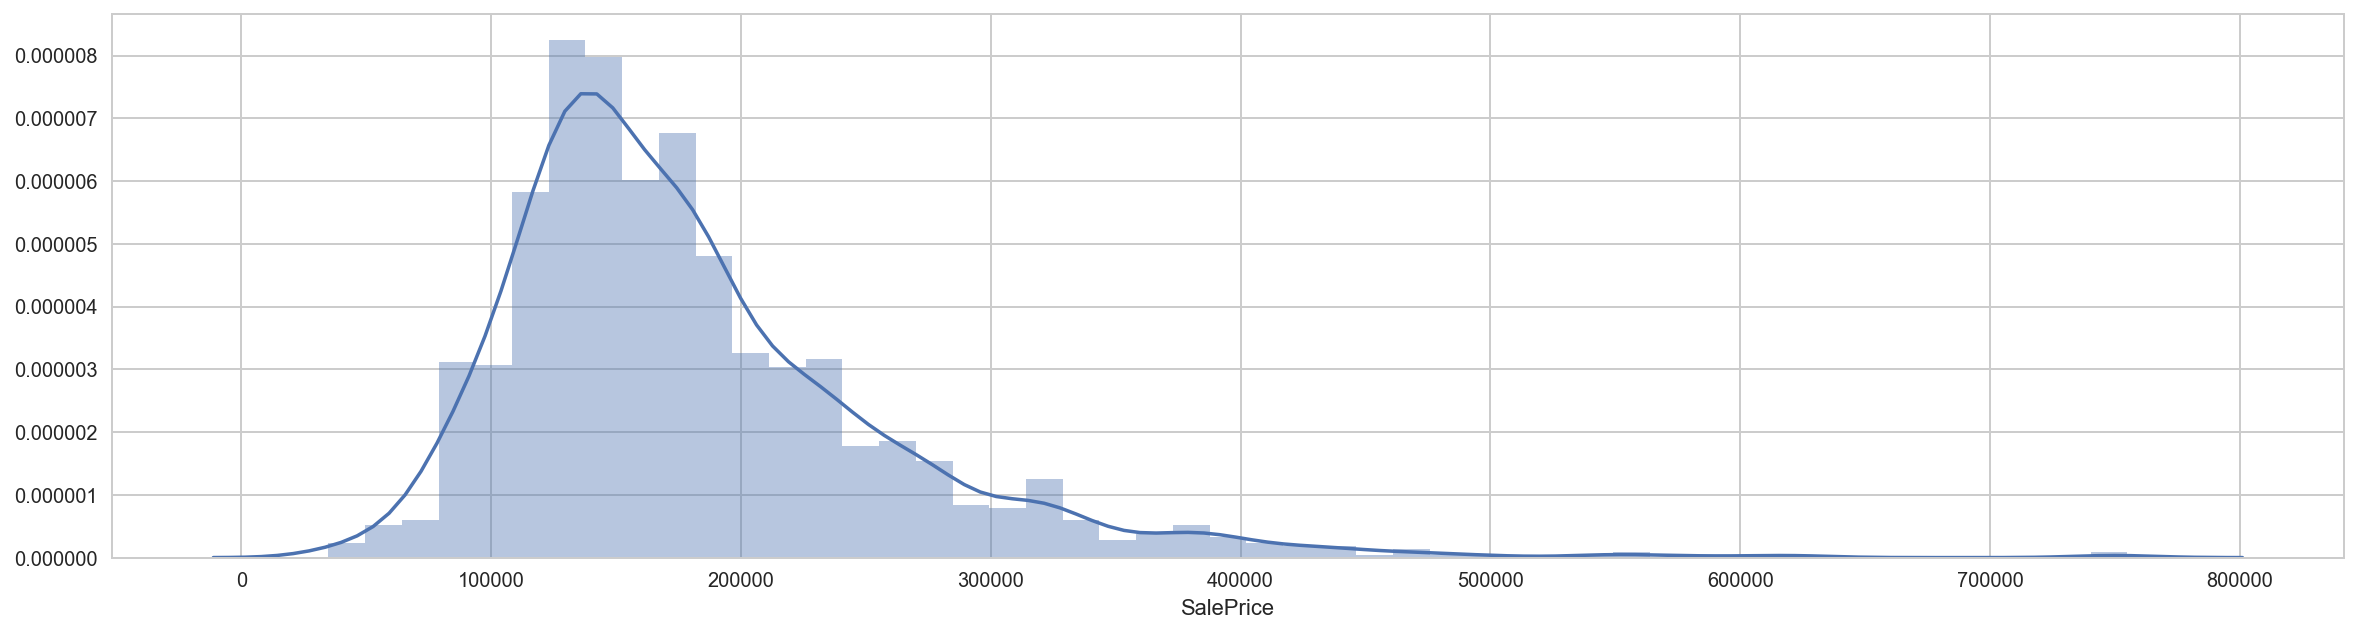

In [15]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.distplot(target, ax=ax1)

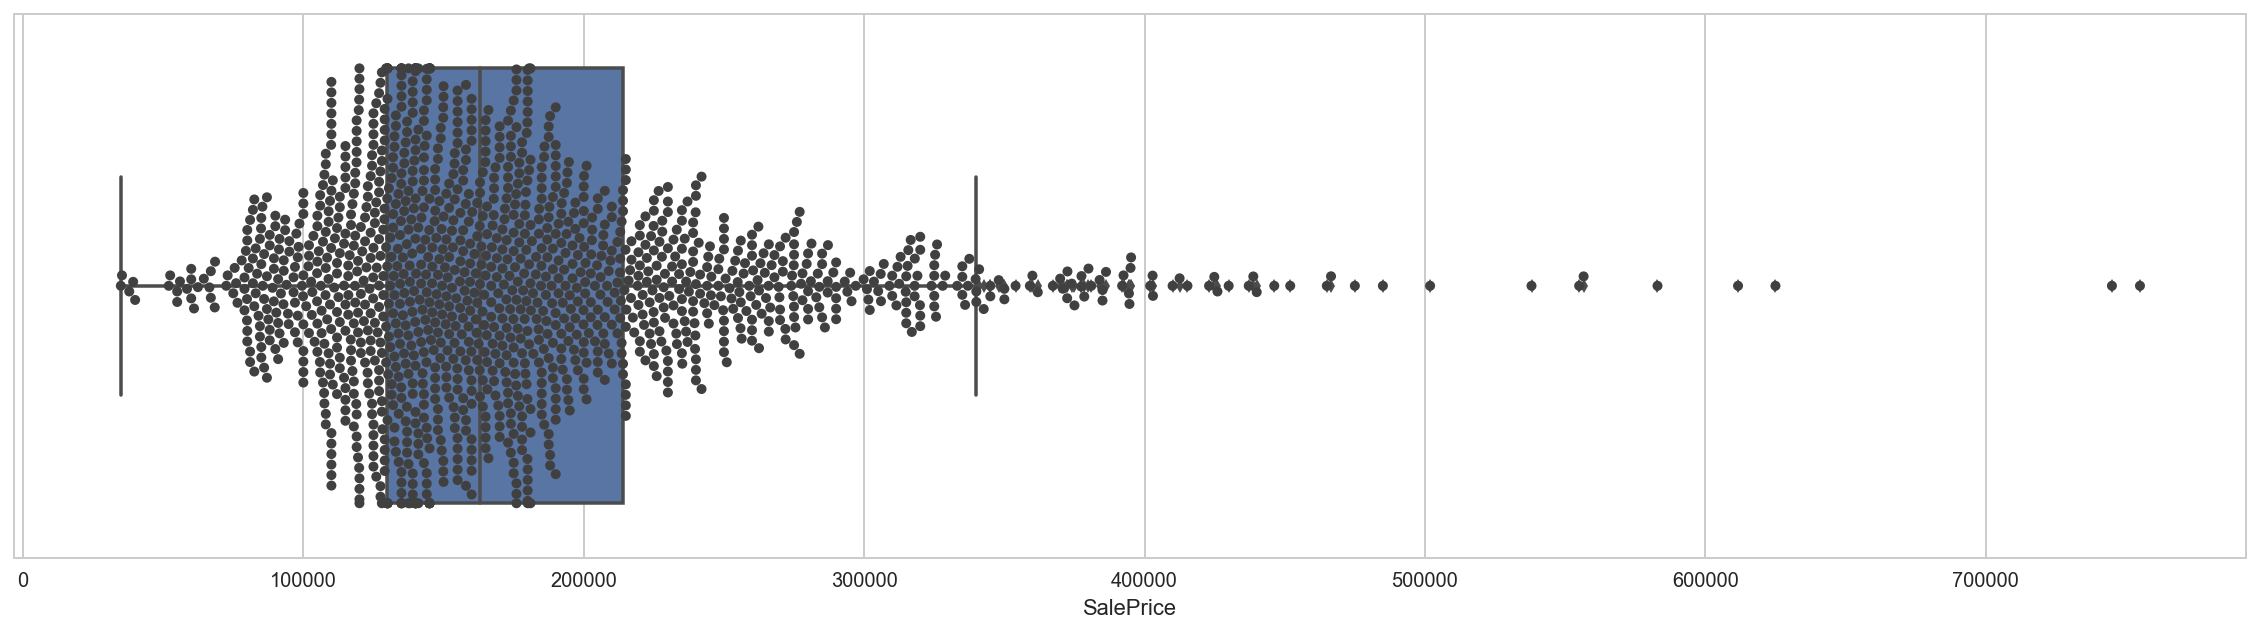

In [16]:
fig, ax1 = plt.subplots(figsize=(20,5))
sns.boxplot(target, ax=ax1)
sns.swarmplot(target, ax=ax1, color="0.25")

In [17]:
q25 = target.quantile(0.25)
q75 = target.quantile(0.75)
iqr = q75 - q25
whis_min = q25 - iqr * 1.5
whis_max = q75 + iqr * 1.5
ex_whis_max = q75 + iqr * 3.5
print ex_whis_max
print whis_max
print whis_min

508087.5
340037.5
3937.5


In [18]:
house[house['SalePrice'] > ex_whis_max].sort_values('SalePrice', ascending = False).head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
691           60       RL        104.0    21535   Pave   NaN      IR1   
1182          60       RL        160.0    15623   Pave   NaN      IR1   
1169          60       RL        118.0    35760   Pave   NaN      IR1   
898           20       RL        100.0    12919   Pave   NaN      IR1   
803           60       RL        107.0    13891   Pave   NaN      Reg   
1046          60       RL         85.0    16056   Pave   NaN      IR1   
440           20       RL        105.0    15431   Pave   NaN      Reg   
769           60       RL         47.0    53504   Pave   NaN      IR2   

     LandContour Utilities LotConfig    ...     PoolArea PoolQC  Fence  \
691          Lvl    AllPub    Corner    ...            0    NaN    NaN   
1182         Lvl    AllPub    Corner    ...          555     Ex  MnPrv   
1169         Lvl    AllPub   CulDSac    ...            0    NaN    NaN   
898          Lvl    AllPub    Inside    ...            0    NaN    NaN   
803          Lvl    AllPub    Inside    ...            0    NaN    NaN   
1046         Lvl    AllPub    Inside    ...            0    NaN    NaN   
440          Lvl    AllPub    Inside    ...            0    NaN    NaN   
769          HLS    AllPub   CulDSac    ...            0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
691          NaN       0      1    2007        WD         Normal     755000  
1182         NaN       0      7    2007        WD        Abnorml     745000  
1169         NaN       0      7    2006        WD         Normal     625000  
898          NaN       0      3    2010       New        Partial     611657  
803          NaN       0      1    2009       New        Partial     582933  
1046         NaN       0      7    2006       New        Partial     556581  
440          NaN       0      4    2009        WD         Normal     555000  
769          NaN       0      6    2010        WD         Normal     538000  

[8 rows x 80 columns]

### Look at Columns with NaN

#### More then 30% of data in features:  Alley, FireplaceQu, PoolQC, Fence, MiscFeature are NaN

In [19]:
null_cols = []

for i,v in enumerate(data.isnull().any()):
    if v == True:
        null_cols.append(data.isnull().any().index[i])

print 'no. of cols with nan = ' + str(len(null_cols))
print null_cols
print ''
print data[null_cols].isnull().sum()
print ''
data[null_cols].info()

no. of cols with nan = 19
['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 19 columns):
LotFrontage     1191 non-null float64
Alley           89 non-null object
MasVnrType      1442 non-null object
MasVnrArea      1442 non-null float64
BsmtQual        1413 non-null object
BsmtCon

** All categorical NaN values represent a feature the house do not have like no pool, garage or basement. Replace categorical NaN values with NO **

In [20]:
data[categorical] = data[categorical].fillna('NIL')
## remaining columns with NaN values are LotFrontage, MasVnrArea, GarageYrBlt

### Do a boxplot of all categorical feature against 'SalePrice'

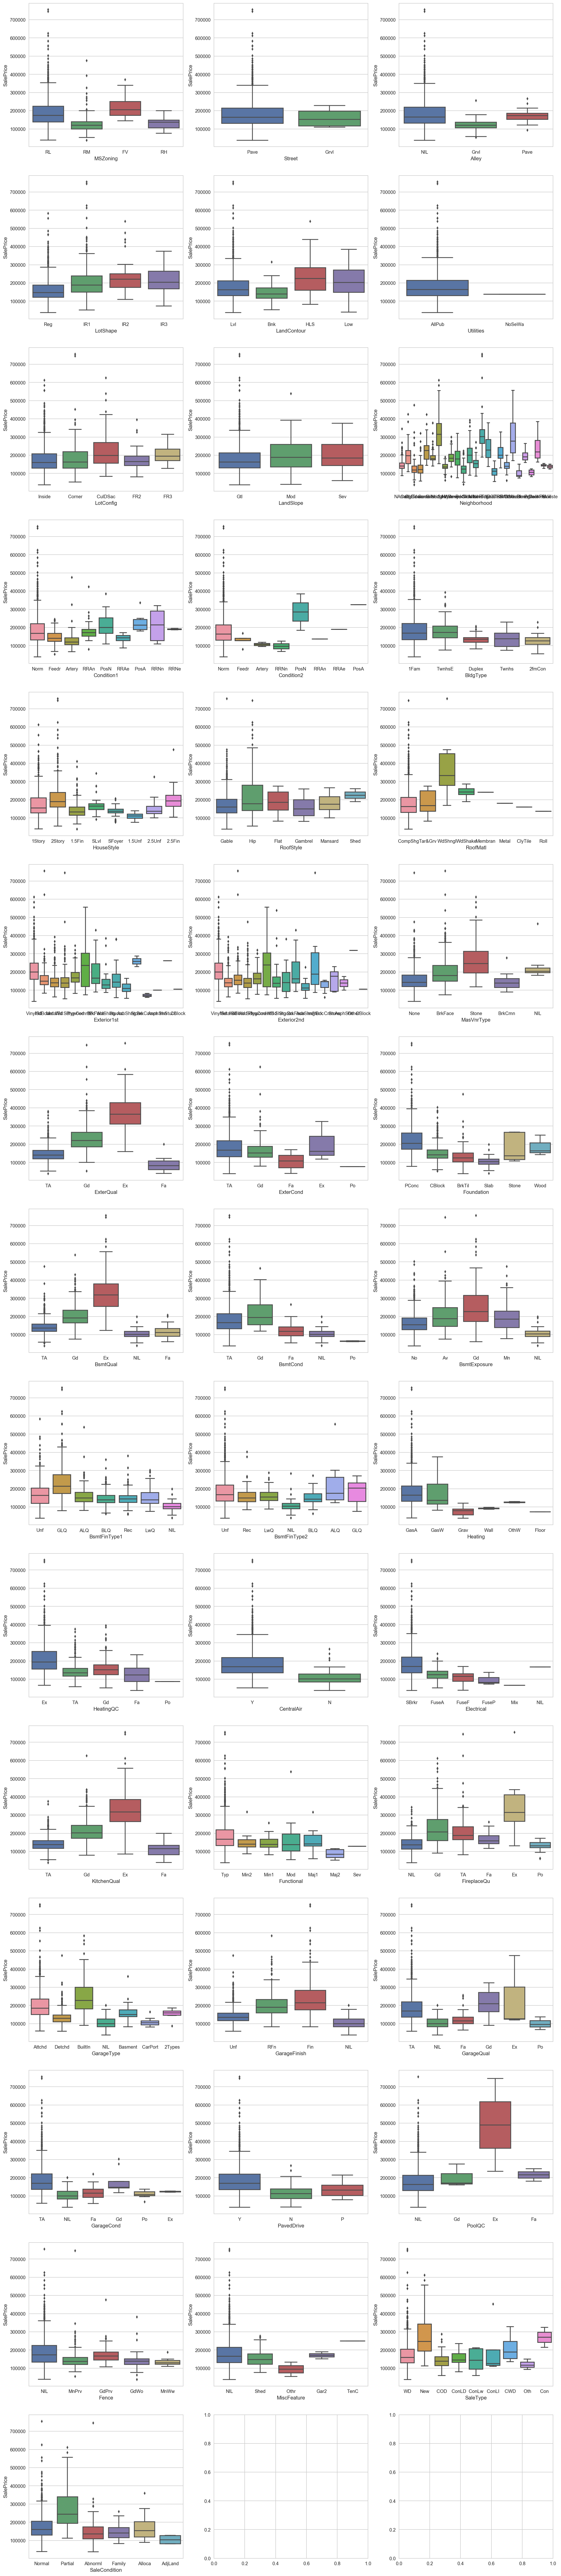

In [21]:
# Use categorical cols, no. of categorical cols = 43
    
fig, axes =plt.subplots(15,3, figsize=(20,100))
axes = axes.flatten()
for ax, plot in zip(axes, categorical):
    order = data[plot].value_counts().index
    sns.boxplot(x=plot, y='SalePrice', order=order, data=data, ax=ax)

### Features that affect SalePrice greatly

    1) Neighborhood -- fixed
    2) Condition 1 -- fixed
    3) Condition 2 -- fixed
    4) Roof Matl -- renov
    5) ExterQual -- renov
    6) BsmtQual -- fixed
    7) KitchenQual -- renov
    8) FireplaceQu -- renov
    9) PoolQC -- renov
    
    
renov_col = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
             'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
             'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

Features with null values that have a significant effect on the SalePrice:

    1) PoolQC
    2) FireplaceQu
    3) BsmtQual

Features with more then 30% null values

    1) Alley - DROP
    2) MiscFeature - DROP
    3) PoolQC - DROP
    4) FireplaceQu - DROP
    5) Fence   - DROP


### Do a scatterplot of all numerical feature against 'SalePrice'

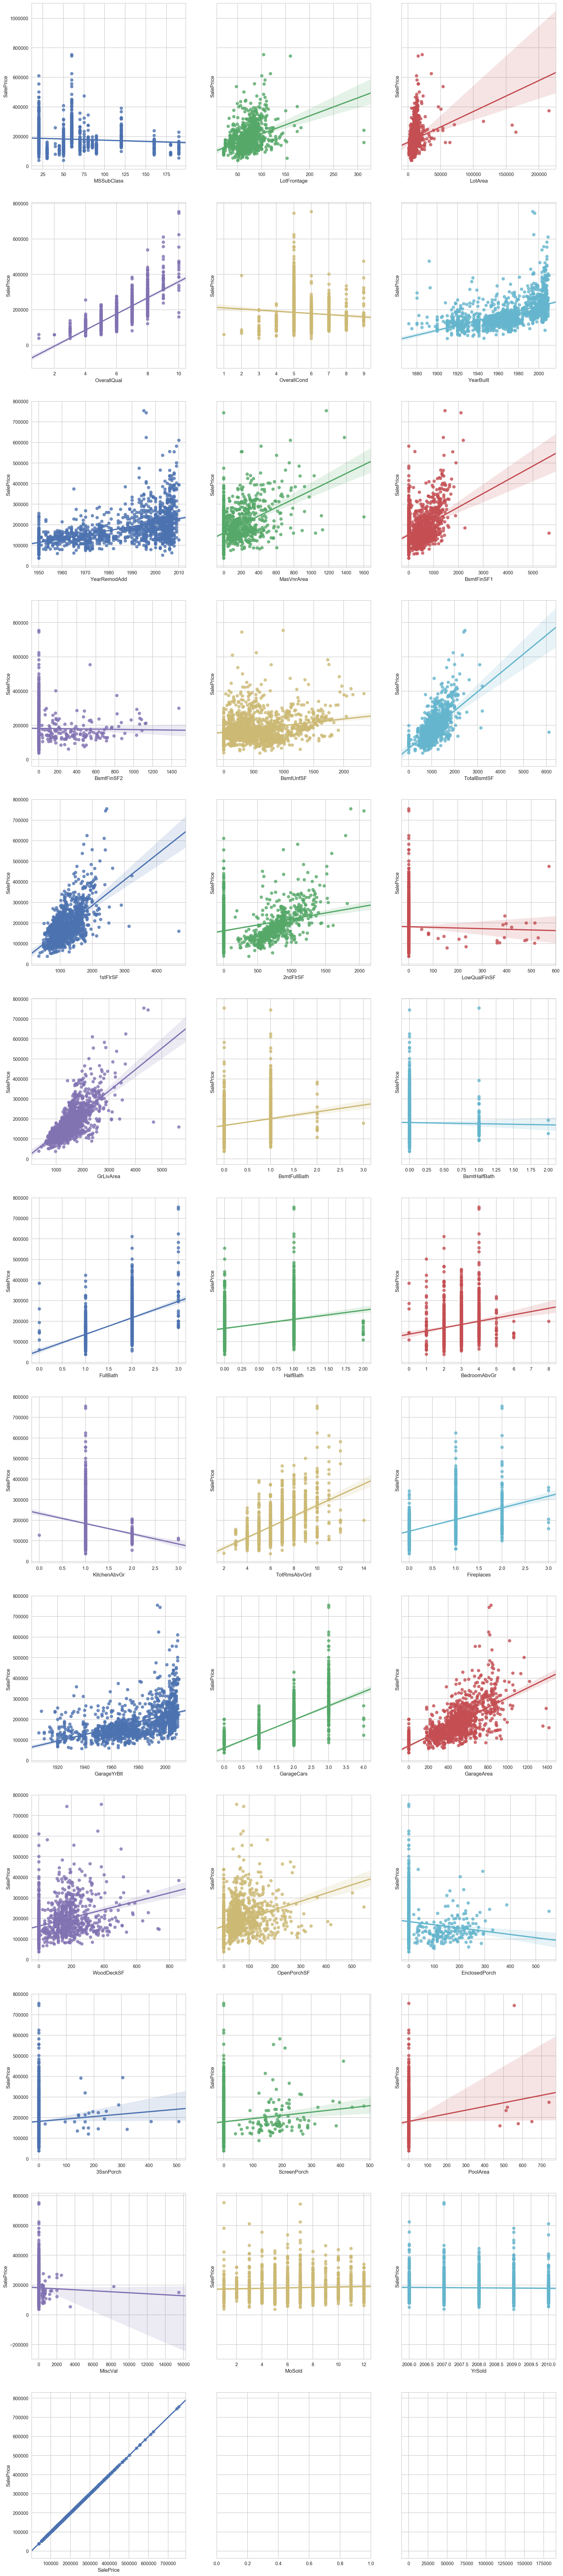

In [22]:
# Use numeric cols, no. of numeric cols = 37
    
fig, axes =plt.subplots(nrows = 13, ncols = 3, figsize=(20,100), sharey='row')
axes = axes.flatten()
for ax, plot in zip(axes, numeric):
    sns.regplot(data[plot], data['SalePrice'], data=data, ax=ax, scatter_kws={"linewidths":0.05})
    #ax.set_xlabel(plot)
    #ax.set_ylabel('SalePrice')

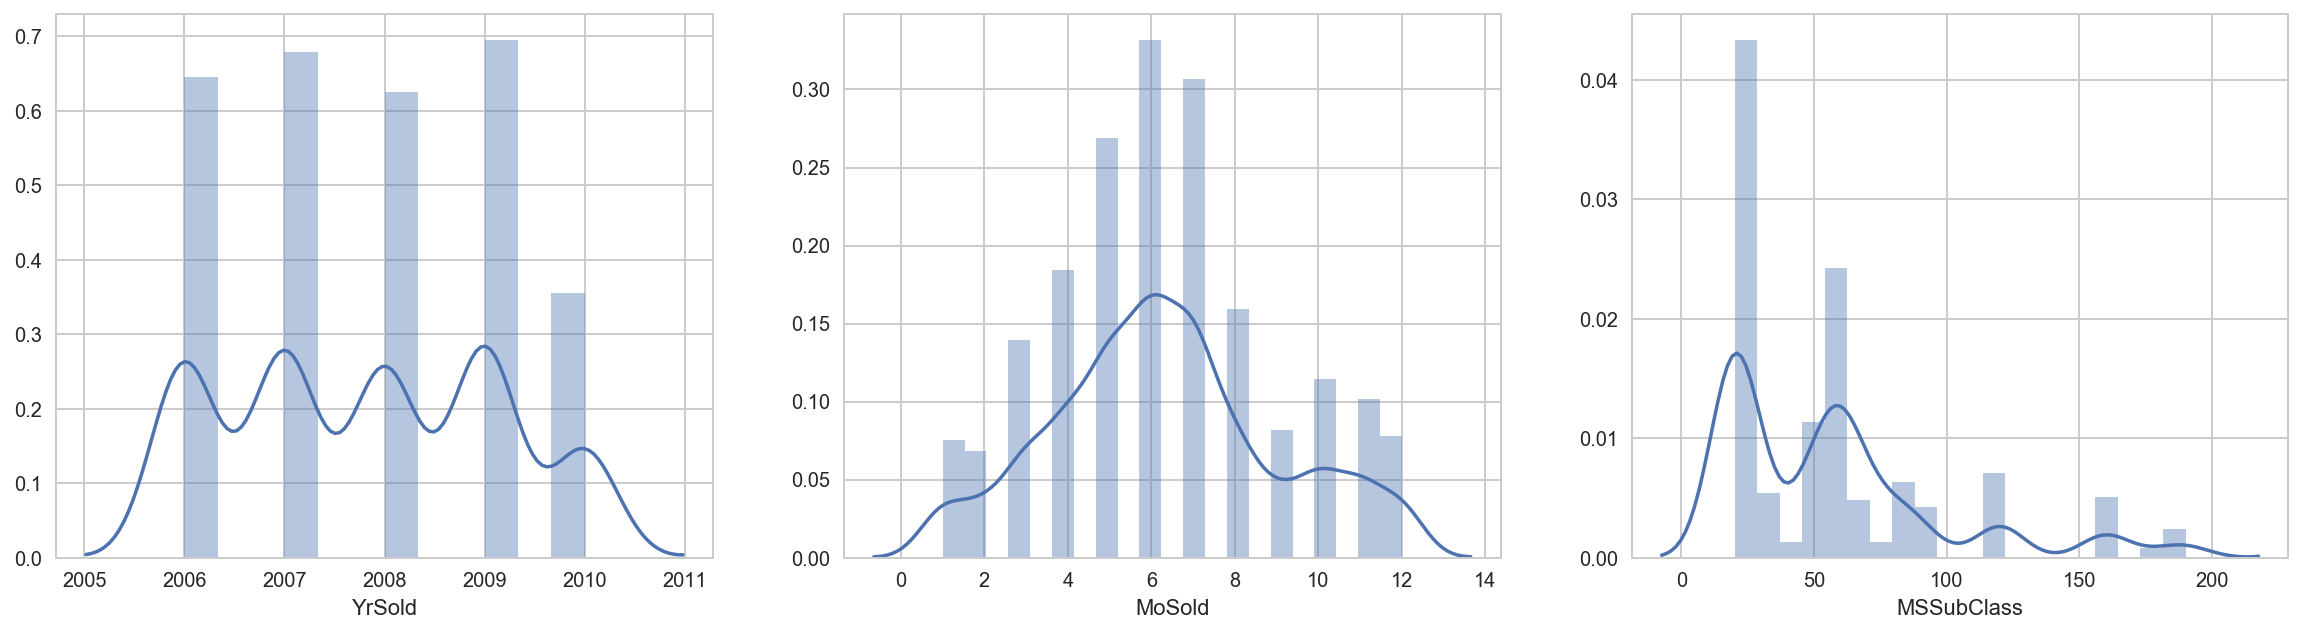

In [23]:

axes = axes.flatten()


fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data['YrSold'], ax=axes[0])
sns.distplot(data['MoSold'], ax=axes[1])
sns.distplot(data['MSSubClass'], ax=axes[2])

### Features that seem correlated with SalePrice

    1) OverallQual and OverallCond
    2) GrLivArea 
    3) TotalBsmtSF
    4) 1stFlrSF
    5) TotRmsAbvGrd
    6) GarageArea
   
Some of the features have similar scatter:

YearBuilt, GarageYrBlt, YearRemodAdd

TotalBsmtSF, 1stFlrSF, MasVnrArea

### Look at heatmap to check for correlated values

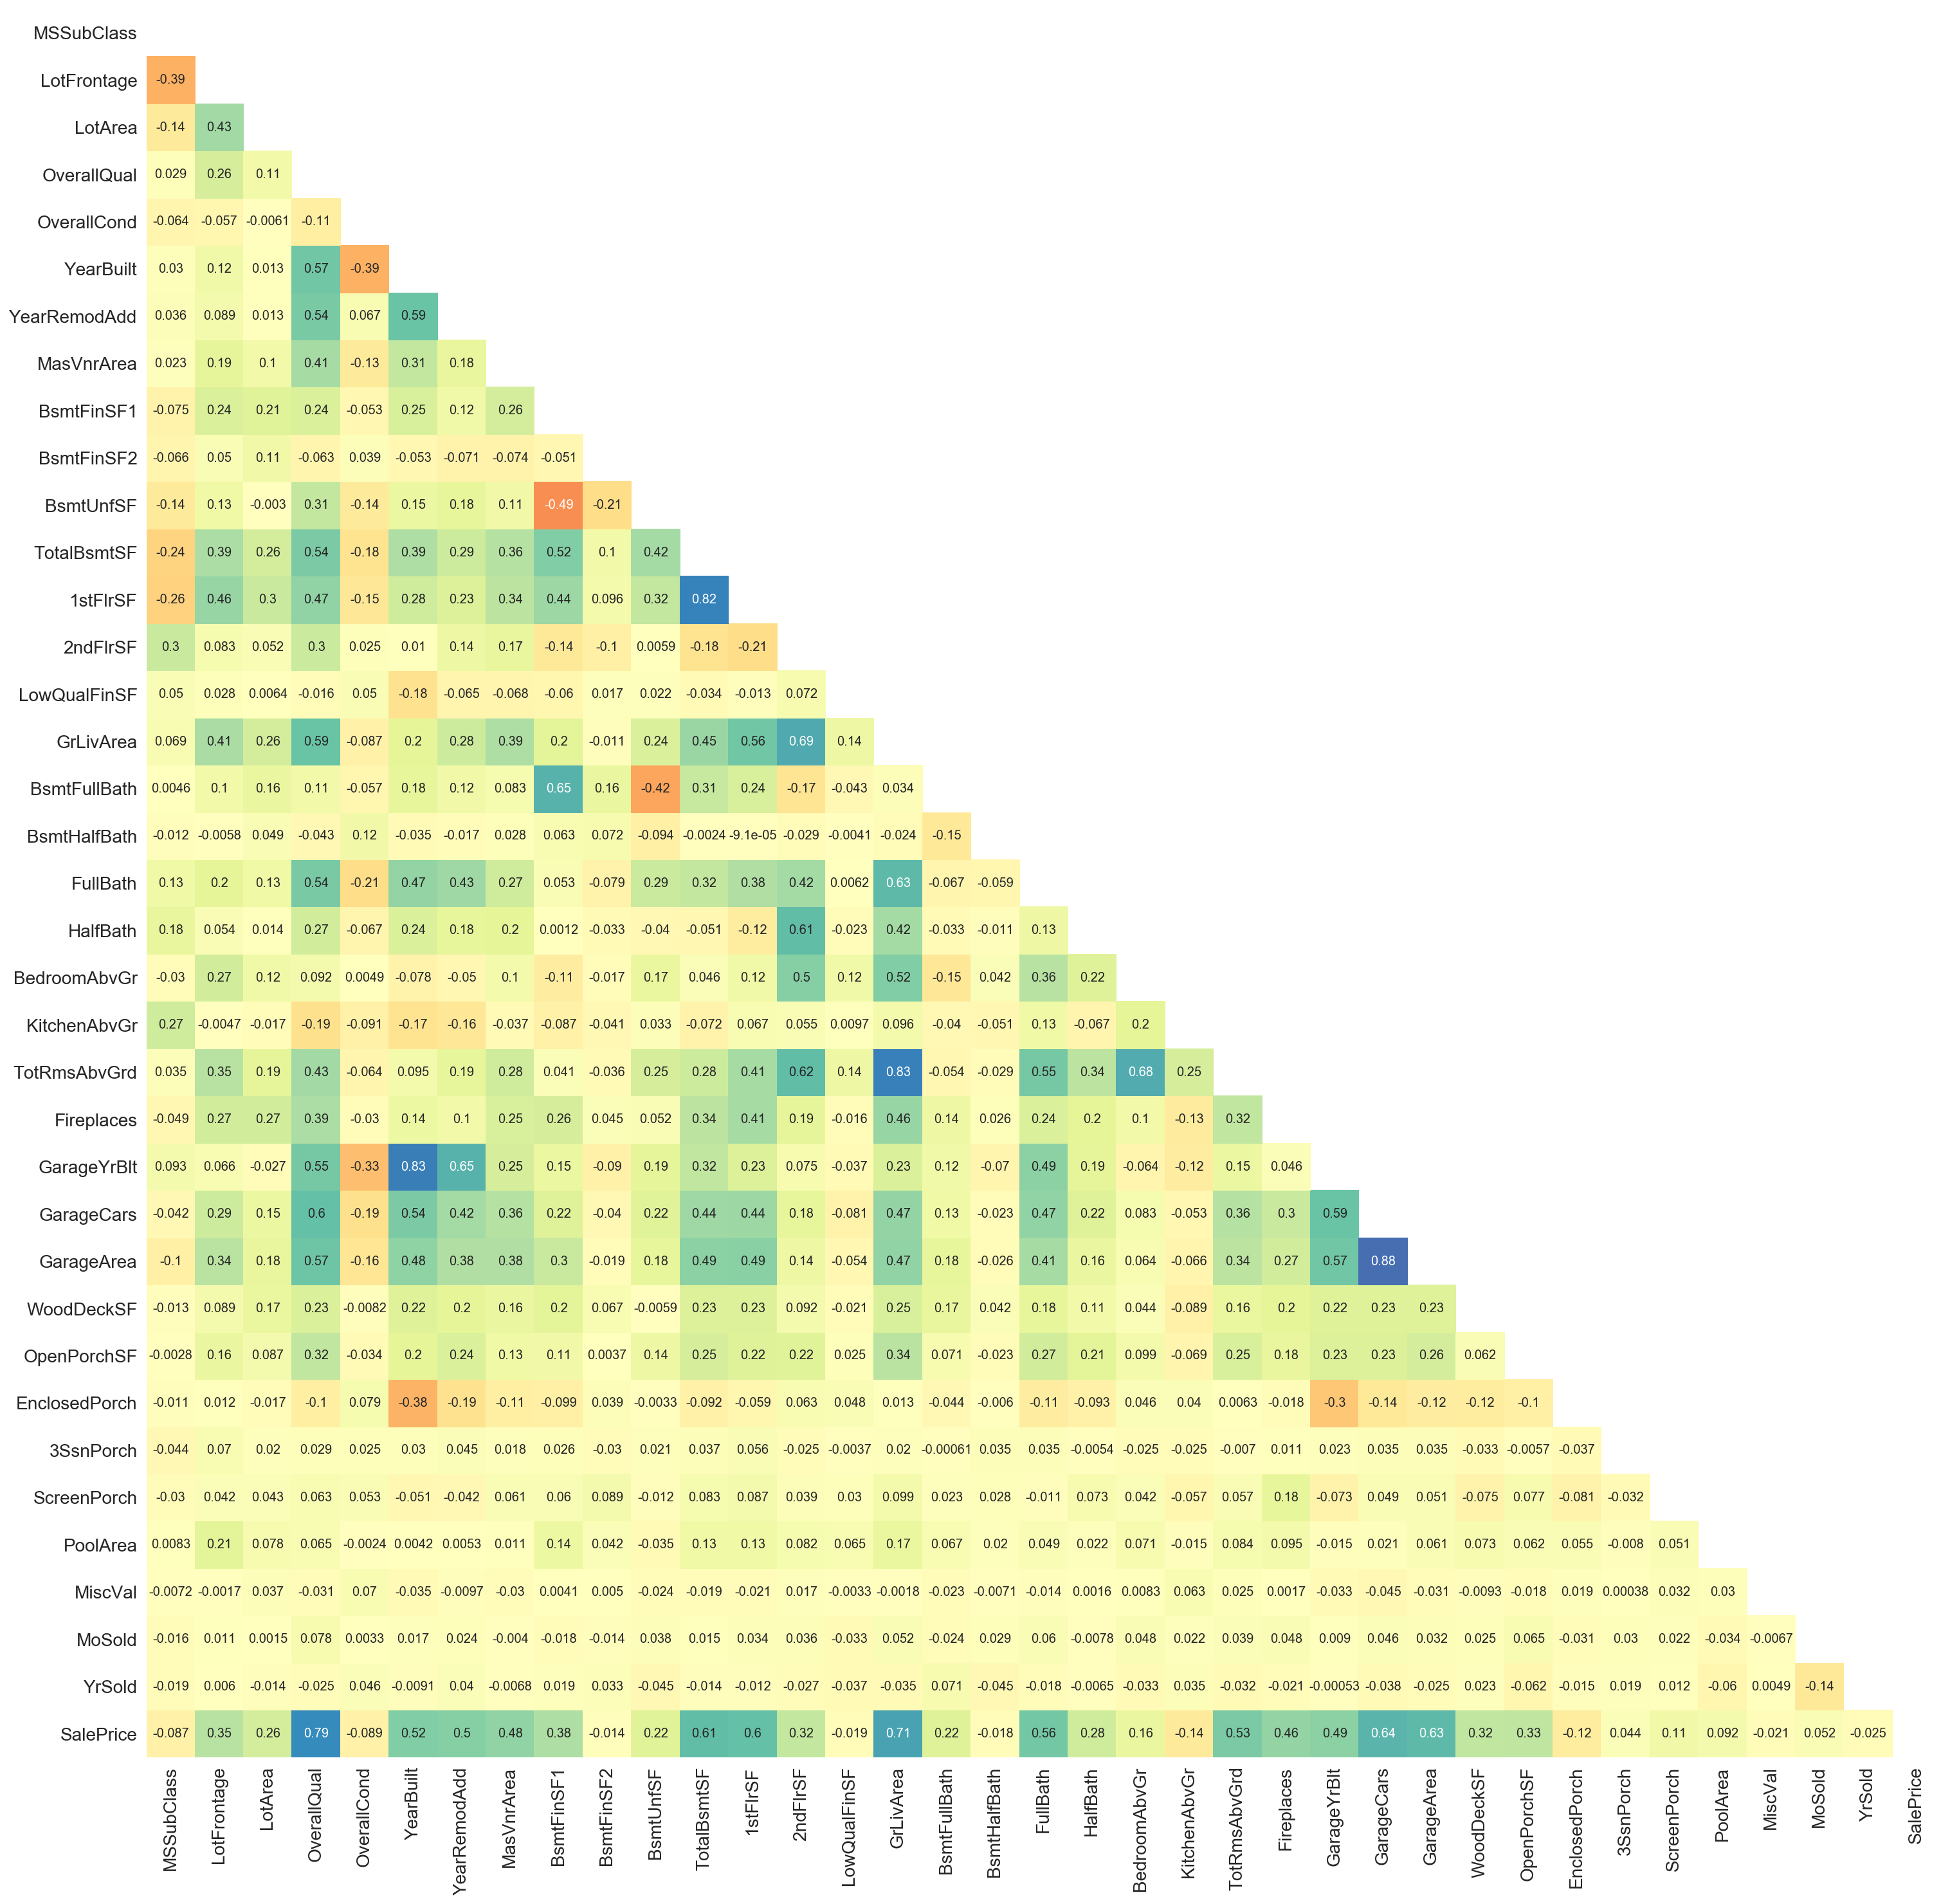

In [24]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(25,25))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='Spectral', cbar=False)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

Two things to look for:

    1) Features that are correlated with other Features. (DROP these Feature)
    2) Features that are correlated with SalePrice. (Include these Feature)

2 Features correlated with each other. Take out those more then 0.75 correlation value.

    1) TotalBsmtSF and 1stFlrSF -- drop TotalBsmtSF (doesnt matter which one)
    2) YearBuilt and GarageYrBlt -- drop GarageYrBlt as correlation < YearBuilt
    2) TotRmsAbvGrd and GrLivArea -- drop TotRmsAbvGrd (less granular)
    3) GarageCars and GarageArea -- drop GarageCars (less granular)

In [25]:
correlation = data.corr().abs()
corr = correlation['SalePrice']
print corr.sort_values(ascending=False).head(20)

SalePrice       1.000000
OverallQual     0.789031
GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
1stFlrSF        0.603300
FullBath        0.556674
TotRmsAbvGrd    0.533355
YearBuilt       0.517602
YearRemodAdd    0.501186
GarageYrBlt     0.486058
MasVnrArea      0.475950
Fireplaces      0.463264
BsmtFinSF1      0.384475
LotFrontage     0.354848
OpenPorchSF     0.329491
WoodDeckSF      0.320770
2ndFlrSF        0.319774
HalfBath        0.280882
Name: SalePrice, dtype: float64


#### TotalBsmtSF vs 1stFlrSF

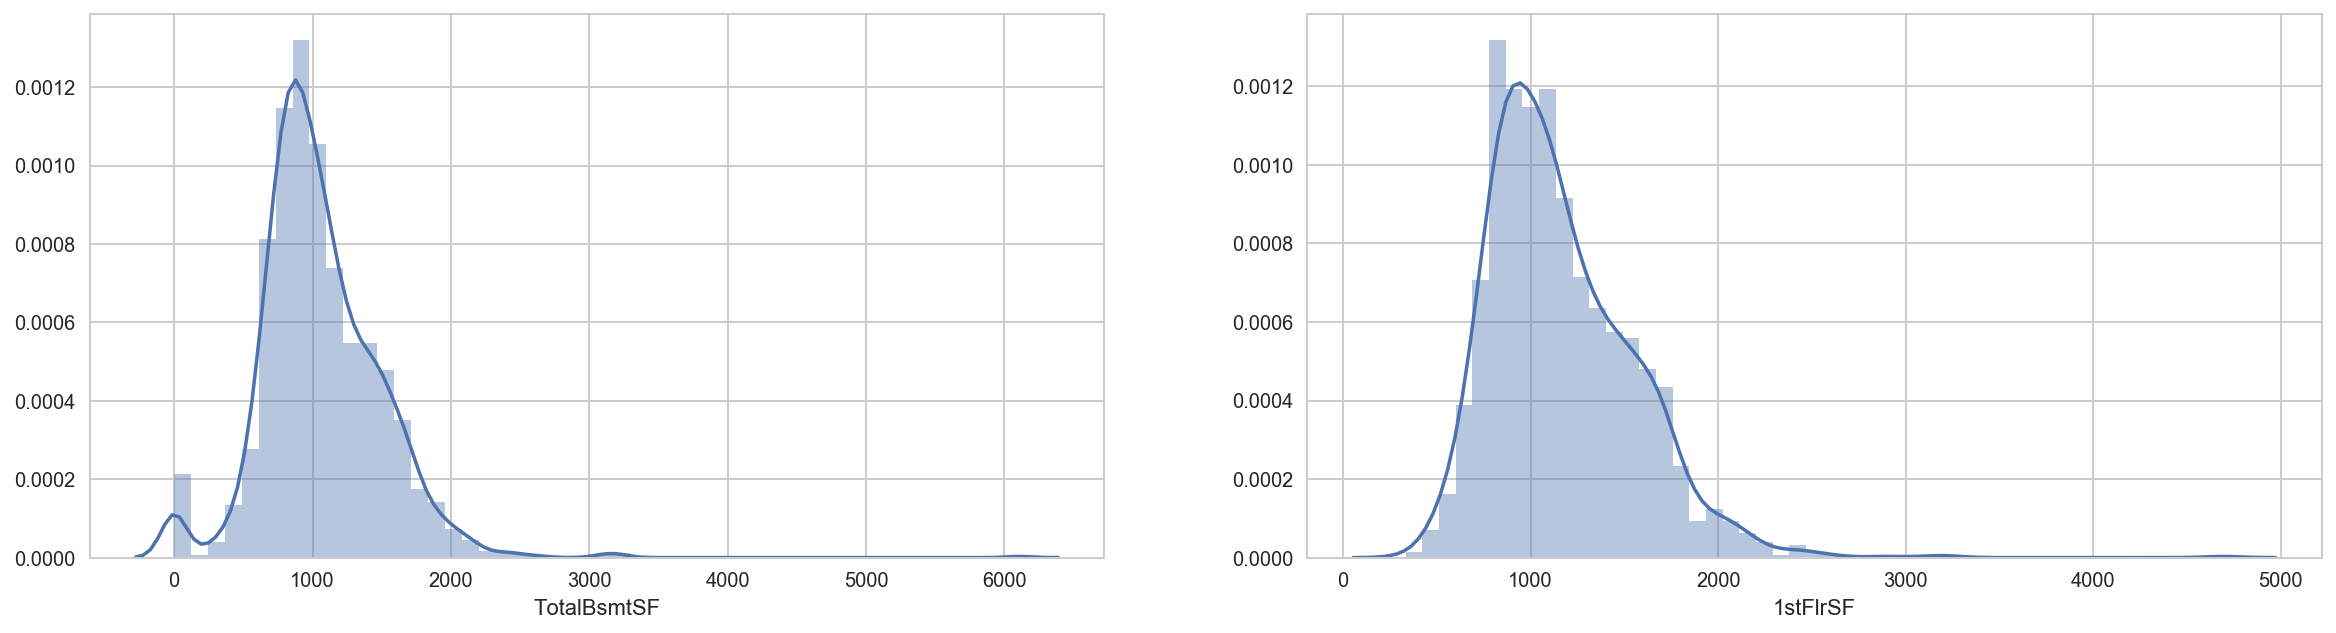

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data['TotalBsmtSF'], ax=ax1)
sns.distplot(data['1stFlrSF'], ax=ax2)

#### YearBuilt vs GarageYrBlt

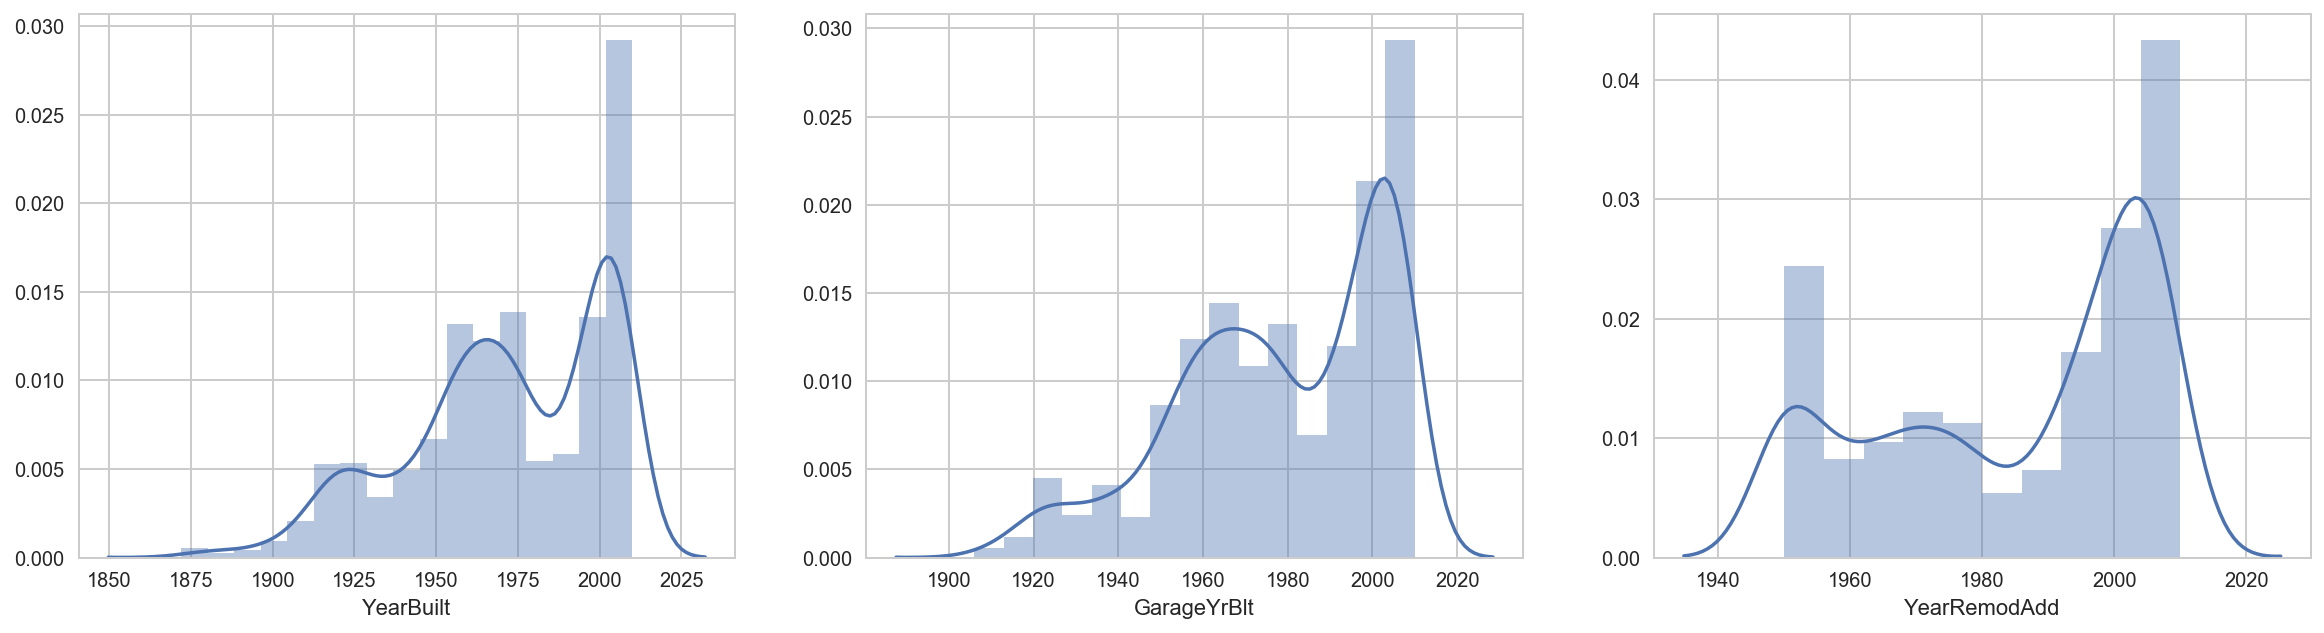

In [27]:
test = data[data['GarageYrBlt'].notnull()]

fig, (ax1,ax2,ax3) =plt.subplots(1,3, figsize=(20,5))
sns.distplot(data['YearBuilt'], ax=ax1)
sns.distplot(test['GarageYrBlt'], ax=ax2)
sns.distplot(data['YearRemodAdd'], ax=ax3)

#### YearBuilt has a similar distribution as GarageYrBlt. Impute missing values of GarageYrBlt from YearBuilt.

In [28]:
miss_row = data[data['GarageYrBlt'].isnull()].index

## impute values for GarageYrBlt
data.loc[miss_row, 'GarageYrBlt'] = data.loc[miss_row].YearBuilt.values

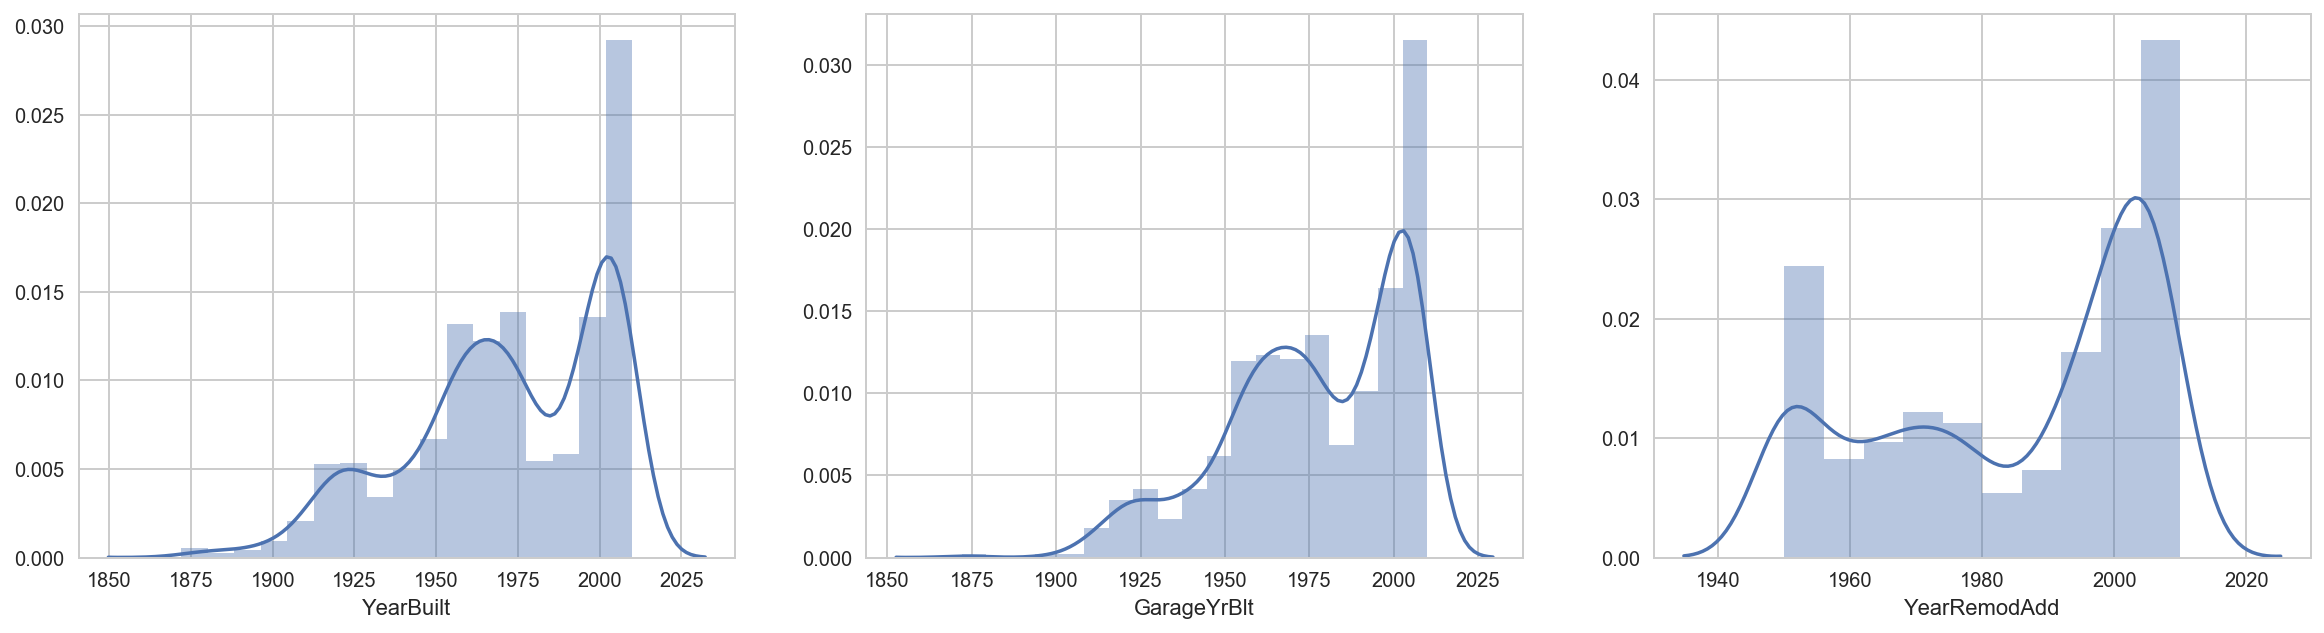

In [29]:
fig, (ax1,ax2,ax3) =plt.subplots(1,3, figsize=(20,5))
sns.distplot(data['YearBuilt'], ax=ax1)
sns.distplot(data['GarageYrBlt'], ax=ax2)
sns.distplot(data['YearRemodAdd'], ax=ax3)

#### TotRmsAbvGrd vs GrLivArea

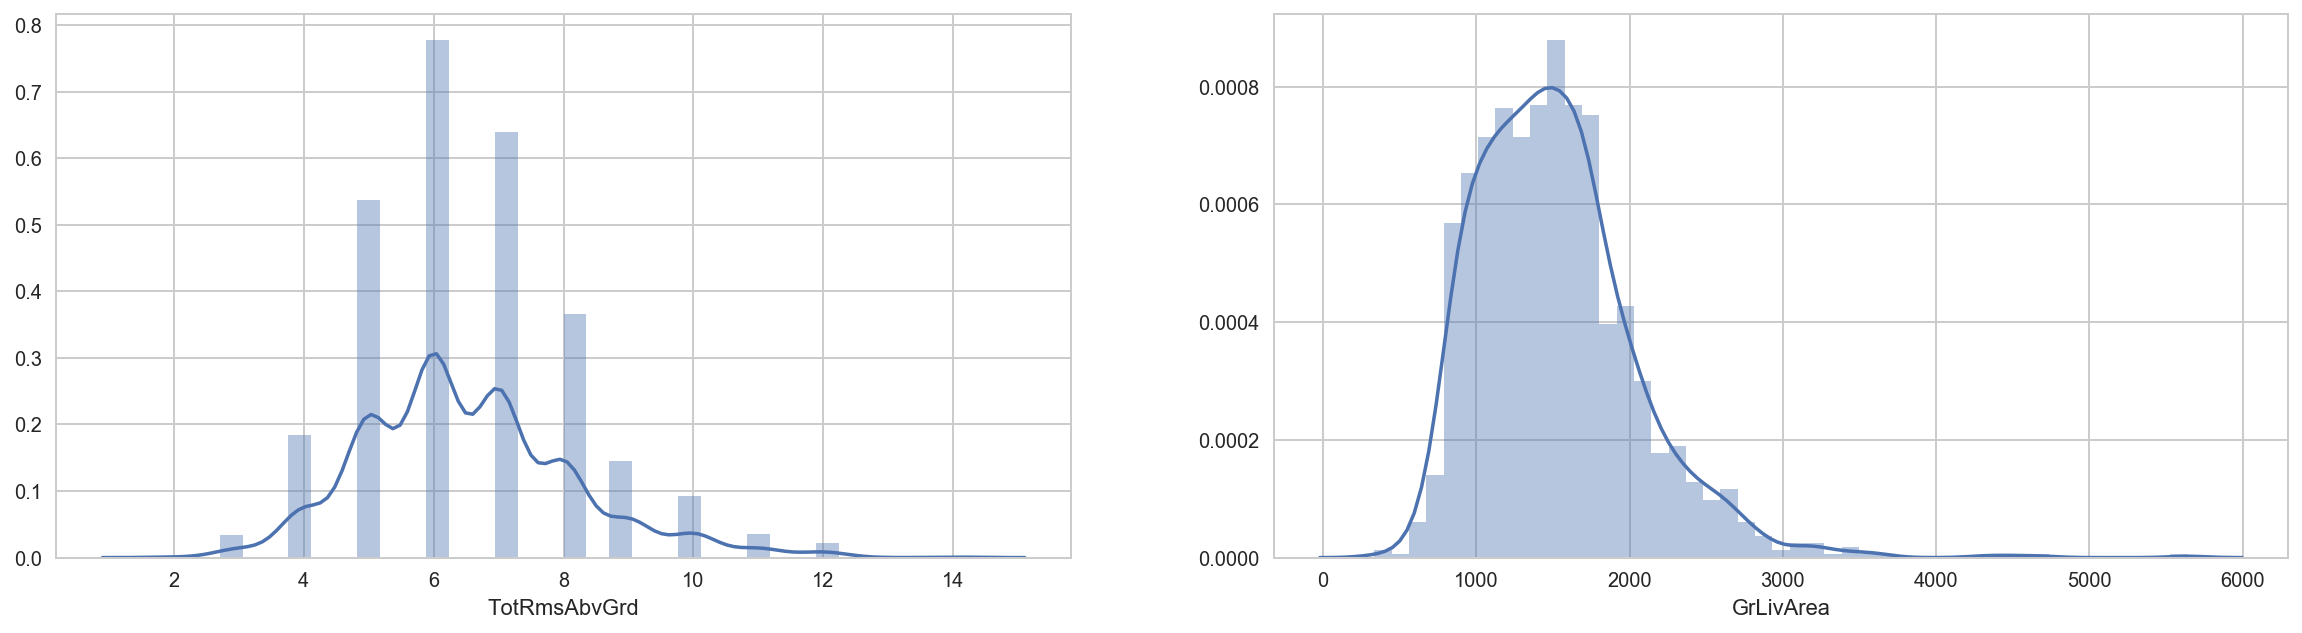

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data['TotRmsAbvGrd'], ax=ax1)
sns.distplot(data['GrLivArea'], ax=ax2)

#### GarageArea vs GarageCars

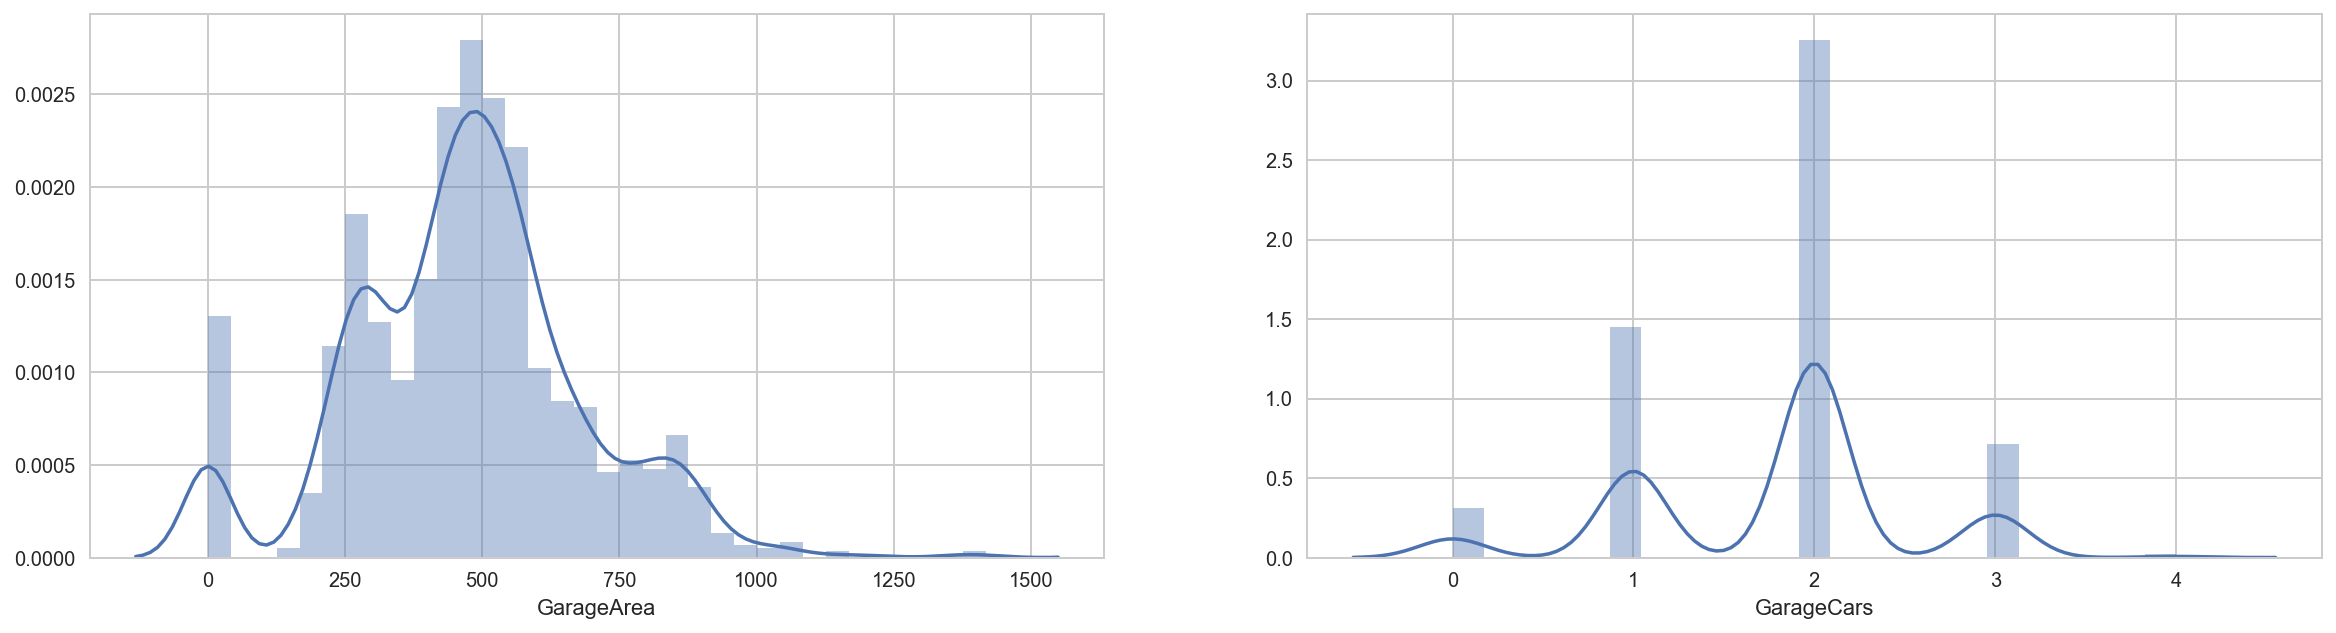

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data['GarageArea'], ax=ax1)
sns.distplot(data['GarageCars'], ax=ax2)

**2 more numerical features with NaN values: LotFrontage, MasVnrArea. Look at general stats of these 2 columns**

In [32]:
## From before GarageYrBlt and YearBuilt seems be have similar distribution

data[['LotFrontage','MasVnrArea']].describe()

LotFrontage   MasVnrArea
count  1191.000000  1442.000000
mean     70.052897   104.404300
std      24.301013   181.486539
min      21.000000     0.000000
25%      59.000000     0.000000
50%      70.000000     0.000000
75%      80.000000   166.750000
max     313.000000  1600.000000

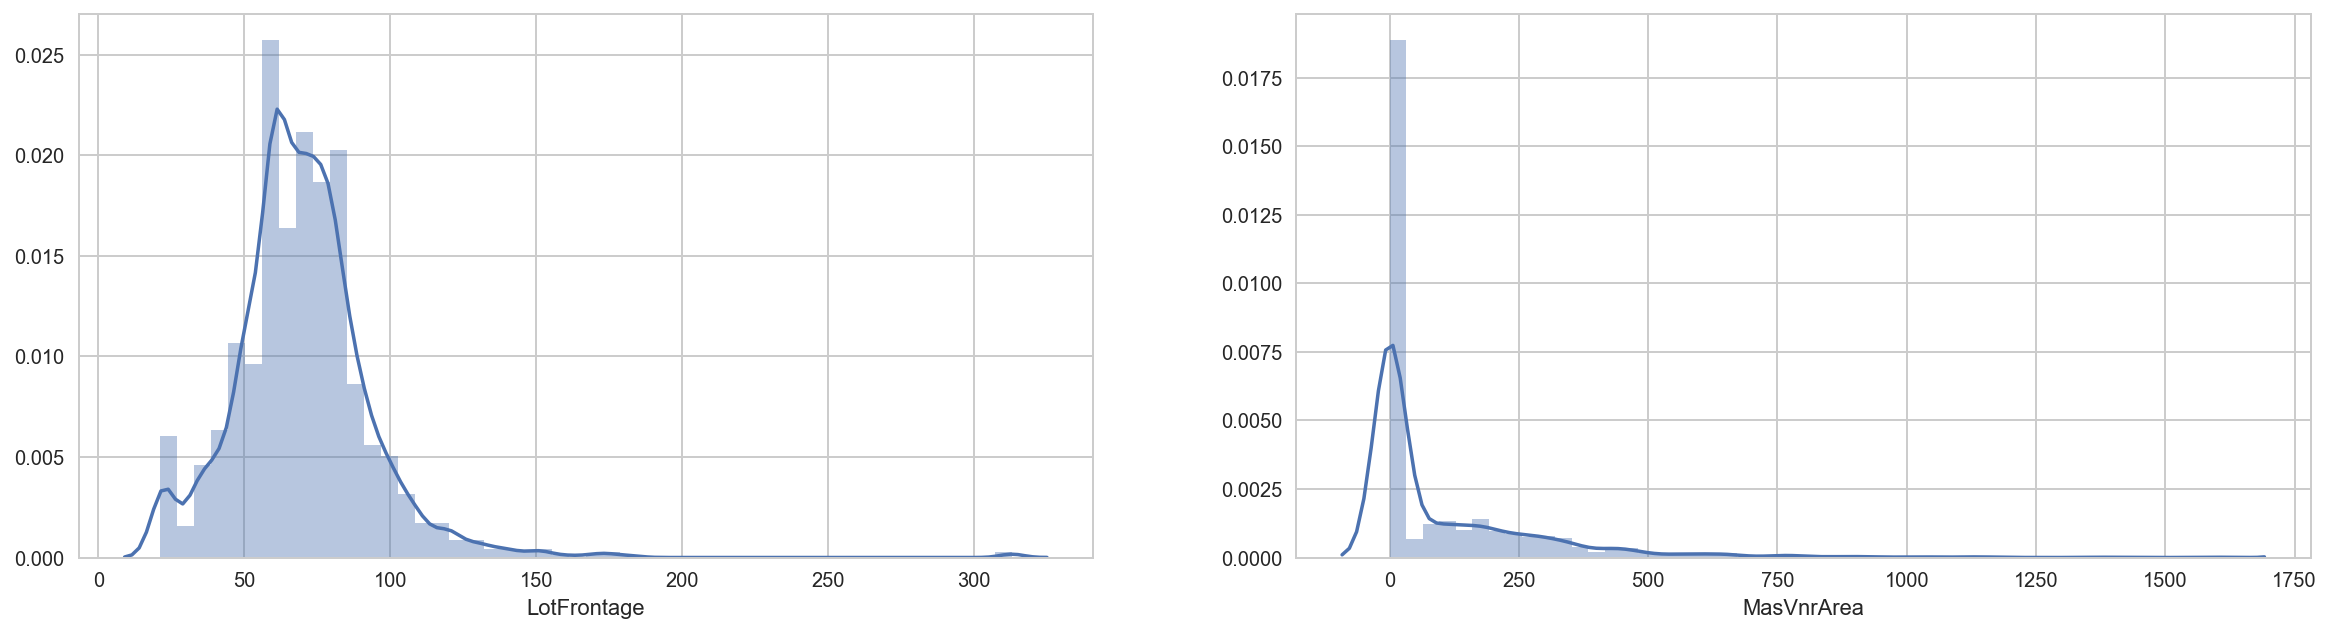

In [33]:
test1 = data[data['LotFrontage'].notnull()]
test2 = data[data['MasVnrArea'].notnull()]


fig, (ax1,ax2) =plt.subplots(1,2, figsize=(20,5))
sns.distplot(test1['LotFrontage'], ax=ax1)
sns.distplot(test2['MasVnrArea'], ax=ax2)

## impute these missing values with median()

In [34]:
lfmedian = data['LotFrontage'].median()
mva = data['MasVnrArea'].median()
data['LotFrontage'] = data['LotFrontage'].fillna(lfmedian)
data['MasVnrArea'] = data['MasVnrArea'].fillna(mva)

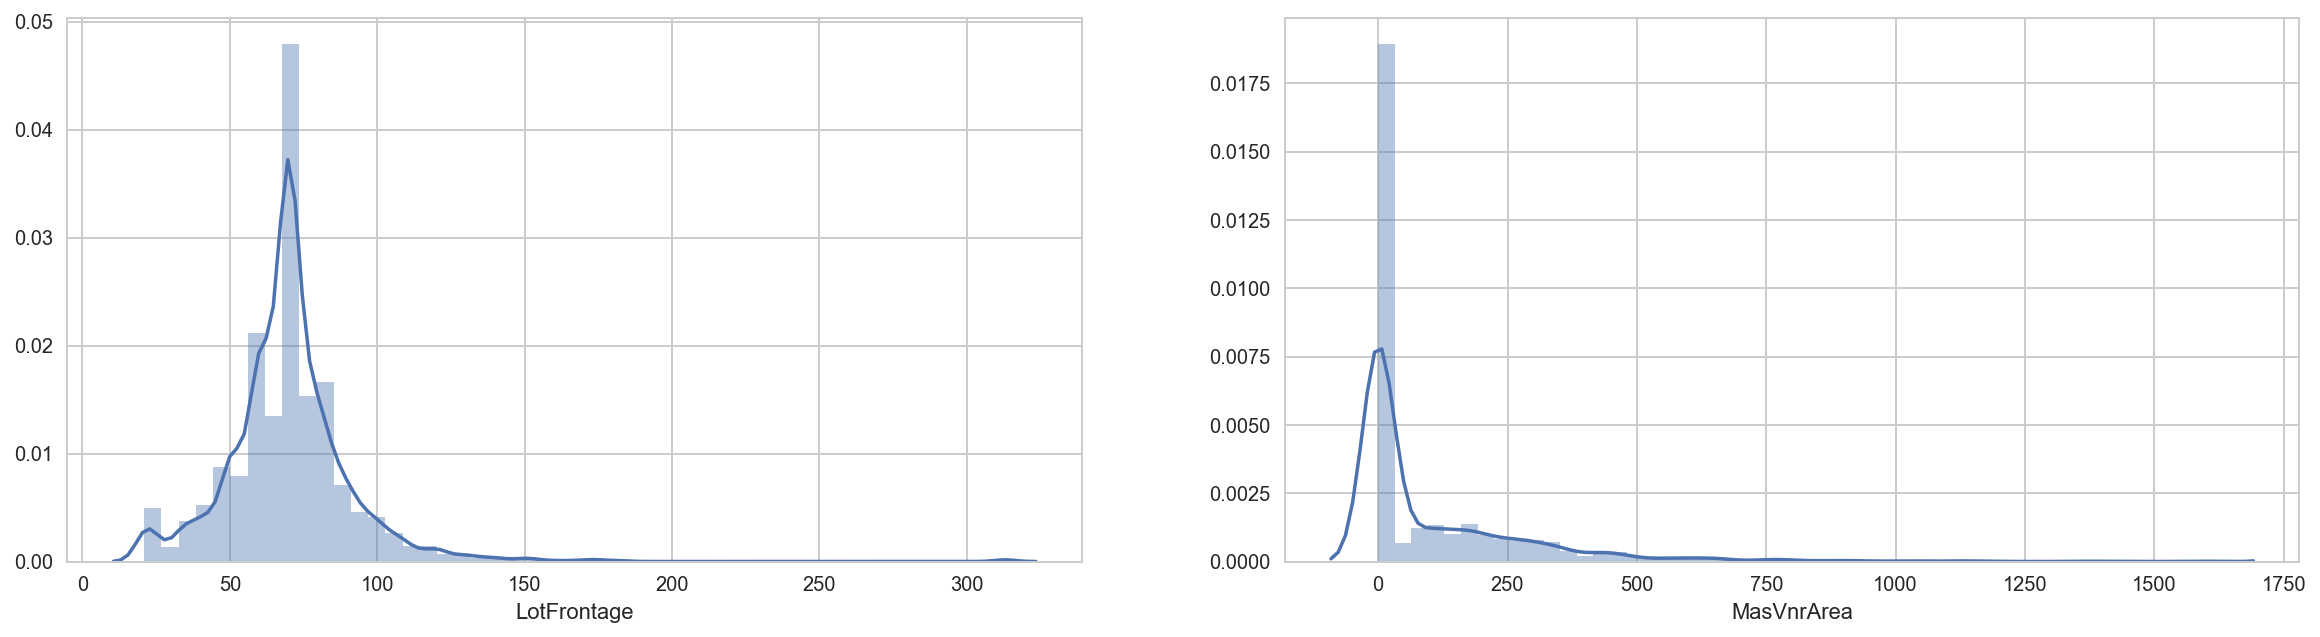

In [35]:
fig, (ax1,ax2) =plt.subplots(1,2, figsize=(20,5))
sns.distplot(data['LotFrontage'], ax=ax1)
sns.distplot(data['MasVnrArea'], ax=ax2)

----------
#### All NaN filled

In [36]:
### NO MORE NaN values. Check data again
print data.isnull().any().sum()
print data.shape
data.head()

0
(1450, 80)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NIL      Reg   
1          20       RL         80.0     9600   Pave   NIL      Reg   
2          60       RL         68.0    11250   Pave   NIL      IR1   
3          70       RL         60.0     9550   Pave   NIL      IR1   
4          60       RL         84.0    14260   Pave   NIL      IR1   

  LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside    ...            0    NIL   NIL   
1         Lvl    AllPub       FR2    ...            0    NIL   NIL   
2         Lvl    AllPub    Inside    ...            0    NIL   NIL   
3         Lvl    AllPub    Corner    ...            0    NIL   NIL   
4         Lvl    AllPub       FR2    ...            0    NIL   NIL   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0         NIL       0      2    2008        WD         Normal     208500  
1         NIL       0      5    2007        WD         Normal     181500  
2         NIL       0      9    2008        WD         Normal     223500  
3         NIL       0      2    2006        WD        Abnorml     140000  
4         NIL       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

#### All NaN filled
----------

**Extract renovatable and non renovatable**

renov_col = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
             'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
             'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
             
fixed = [c for c in house.columns if c not in renov_col]

In [37]:
# extract renov_col and fixed

renov_df = data[renov_col]
fixed_df = data[fixed]

print renov_df.shape
print fixed_df.shape

(1450, 21)
(1450, 59)


Dropping columns that do not have a significant contribution to SalePrice

    1) Alley
    2) MiscFeature
    3) Fence -- renov features
    4) TotalBsmtSF
    5) GarageYrBlt
    6) TotRmsAbvGrd
    7) GarageCars

In [38]:
# Drop Alley, MiscFeature, Fence
fixed_df1 = fixed_df.drop('Alley', axis = 1)
fixed_df1 = fixed_df.drop('MiscFeature', axis = 1)
fixed_df1 = fixed_df.drop('TotalBsmtSF', axis = 1)
fixed_df1 = fixed_df.drop('GarageYrBlt', axis = 1)
fixed_df1 = fixed_df.drop('GarageCars', axis = 1)
fixed_df1 = fixed_df.drop('TotRmsAbvGrd', axis = 1)

#renov_df1 = renov_df.drop('Fence', axis = 1)


#print renov_df1.shape
print fixed_df1.shape

(1450, 58)


In [39]:
renov_df1 = renov_df.drop('Fence', axis = 1)
print renov_df1.shape

(1450, 20)


 ### All renovatable features are categorical

In [40]:
renov_df1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 20 columns):
Utilities       1450 non-null object
RoofStyle       1450 non-null object
RoofMatl        1450 non-null object
Exterior1st     1450 non-null object
Exterior2nd     1450 non-null object
ExterQual       1450 non-null object
ExterCond       1450 non-null object
BsmtCond        1450 non-null object
BsmtFinType1    1450 non-null object
BsmtFinType2    1450 non-null object
Heating         1450 non-null object
HeatingQC       1450 non-null object
CentralAir      1450 non-null object
Electrical      1450 non-null object
KitchenQual     1450 non-null object
FireplaceQu     1450 non-null object
GarageFinish    1450 non-null object
GarageQual      1450 non-null object
GarageCond      1450 non-null object
PoolQC          1450 non-null object
dtypes: object(20)
memory usage: 277.9+ KB


 ### All numeric features are contained in the fixed, non renovatable features

In [41]:
fixed_df1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 58 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
MasVnrType       1450 non-null object
MasVnrArea       1450 non-null float64
Foundation       1450 non-null object
BsmtQual         1450 non-null object
BsmtExposure     1450 n

### Use fixed_df, convert categorical features using patsy

In [42]:
print fixed_df1.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'MasVnrType', u'MasVnrArea', u'Foundation',
       u'BsmtQual', u'BsmtExposure', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'Functional',
       u'Fireplaces', u'GarageType', u'GarageYrBlt', u'GarageCars',
       u'GarageArea', u'PavedDrive', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea',
       u'MiscFeature', u'MiscVal', u'MoSold', u'YrSold', u'SaleType',
       u'SaleCondition', u'SalePrice'],
      dtype='object')


In [43]:
fixed_df1=fixed_df1.rename(columns = {'1stFlrSF':'O1stFlrSF', '2ndFlrSF':'O2ndFlrSF' , '3SsnPorch':'O3SsnPorch'})

#### patsy need columns name to start with a non number.

In [44]:
import patsy

f= 'SalePrice ~ '+' + '.join([c for c in fixed_df1.columns if not c == 'SalePrice']) + ' -1'
y_p, X_p = patsy.dmatrices(f, data=fixed_df1, return_type='dataframe')
y_p = y_p.values.ravel()

print y_p.shape
print X_p.shape

(1450L,)
(1450, 152)


In [45]:
# Train - YearBuilt < 2010 
# Test - YearBuilt = 2010 

Xp_train = X_p[~X_p['YrSold'].isin([2010.0])]
Xp_test = X_p[X_p['YrSold'].isin([2010.0])]
yp_train = y_p[~X_p['YrSold'].isin([2010.0])]
yp_test = y_p[X_p['YrSold'].isin([2010.0])]

print type(Xp_train)
print type(Xp_test)
print type(yp_train)
print type(yp_test)

print Xp_train.shape
print Xp_test.shape
print yp_train.shape
print yp_test.shape

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(1278, 152)
(172, 152)
(1278L,)
(172L,)


### Linear Regression Model

In [46]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xps = ss.fit_transform(Xp_train)
Xpts = ss.transform(Xp_test)

print type(Xps)
print type(Xpts)
print ''
print Xps.shape
print Xpts.shape
print ''
### Scale Model ###
lr = linear_model.LinearRegression()
model_s = lr.fit(Xps, yp_train)

y_pred_s = model_s.predict(Xpts)

train_score_s = model_s.score(Xps, yp_train)
test_score_s = model_s.score(Xpts, yp_test)

### Not Scale Model ###

lrt = linear_model.LinearRegression()
model_ns = lrt.fit(Xp_train, yp_train)

y_pred_ns = model_ns.predict(Xp_test)

train_score_ns = model_ns.score(Xp_train, yp_train)
test_score_ns = model_ns.score(Xp_test, yp_test)


print 'Scale Model'
print 'R2 score (train set) = ' + str(train_score_s)
print 'R2 score (test set) = ' + str(test_score_s)
print 'RMSE = ' + str(np.sqrt(mean_squared_error(yp_test, y_pred_s)))
print ''
print 'Not Scale Model'
print 'R2 score (train set) = ' + str(train_score_ns)
print 'R2 score (test set) = ' + str(test_score_ns)
print 'RMSE = ' + str(np.sqrt(mean_squared_error(yp_test, y_pred_ns)))


<type 'numpy.ndarray'>
<type 'numpy.ndarray'>

(1278L, 152L)
(172L, 152L)

Scale Model
R2 score (train set) = 0.887437723794
R2 score (test set) = 0.887041091472
RMSE = 26797.8518479

Not Scale Model
R2 score (train set) = 0.887437723794
R2 score (test set) = 0.887041091472
RMSE = 26797.8518479


### Residual Plot

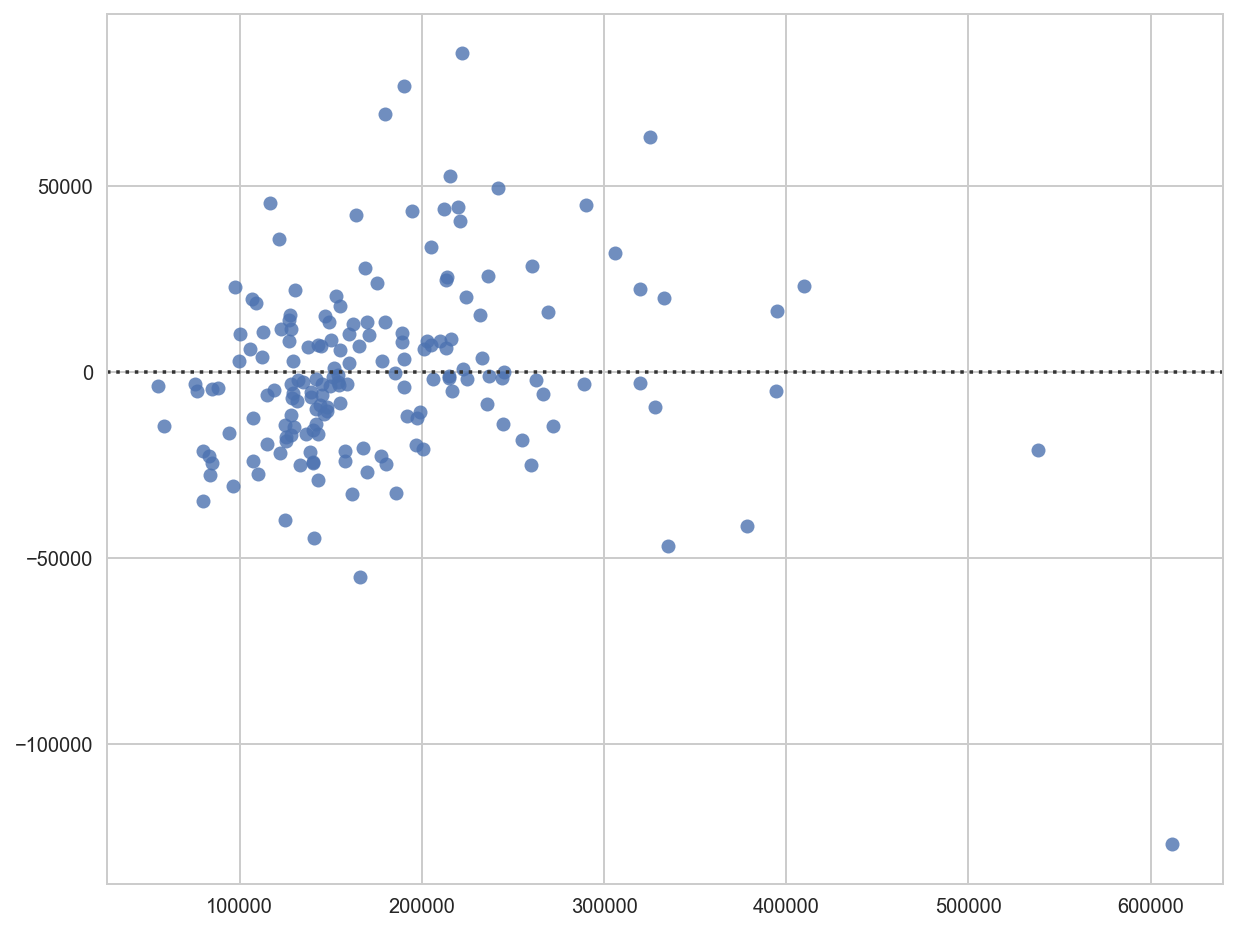

In [47]:
fig, ax =plt.subplots(figsize=(10,8))
sns.residplot(yp_test, y_pred_s, ax=ax)

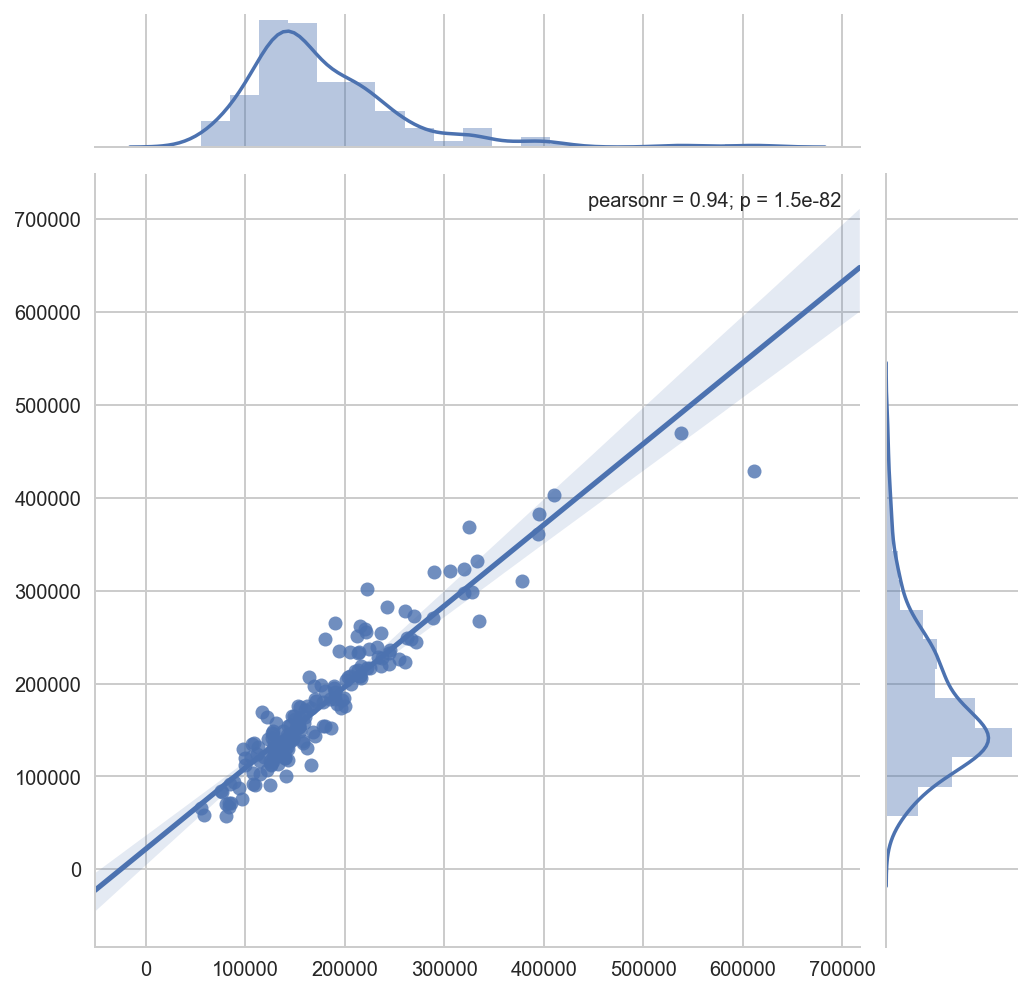

In [48]:
sns.jointplot(yp_test, y_pred_s, kind='reg', size=7)

### Try some Feature Selection

### 1. Recursive Feature Elimination (RFE)

In [49]:
# train is Xps, target is yp_train
# test is Xpts, target is yp_test

from sklearn.feature_selection import RFECV

for fold in range(20):
    lr = linear_model.LinearRegression()
    selector = RFECV(lr, step=1, cv=fold+2)
    selector1 = selector.fit(Xps, yp_train)

    y_pred_rfe = selector1.predict(Xpts)
    train_score_rfe = selector1.score(Xps, yp_train)
    test_score_rfe = selector1.score(Xpts, yp_test)
    print '--------------'
    print 'Fold = ' + str(fold+2)
    print '--------------'
    print 'R2 score (train set) = ' + str(train_score_rfe)
    print 'R2 score (test set) = ' + str(test_score_rfe)
    print 'RMSE = ' + str(np.sqrt(mean_squared_error(yp_test, y_pred_rfe)))
    print '--------------'
    rfecv_columns = np.array(X_p.columns)[selector.support_]
    print rfecv_columns
    print len(rfecv_columns)
    


--------------
Fold = 2
--------------
R2 score (train set) = 0.742966168393
R2 score (test set) = 0.746012959626
RMSE = 40183.2923295
--------------
['BsmtQual[T.TA]' 'OverallQual' 'O1stFlrSF' 'O2ndFlrSF']
4
--------------
Fold = 3
--------------
R2 score (train set) = 0.862014772372
R2 score (test set) = 0.871440025254
RMSE = 28588.5828265
--------------
['Neighborhood[T.Crawfor]' 'Neighborhood[T.NoRidge]'
 'Neighborhood[T.NridgHt]' 'Neighborhood[T.Somerst]'
 'Neighborhood[T.StoneBr]' 'Condition2[T.PosN]' 'BldgType[T.2fmCon]'
 'BsmtQual[T.Fa]' 'BsmtQual[T.Gd]' 'BsmtQual[T.NIL]' 'BsmtQual[T.TA]'
 'BsmtExposure[T.Gd]' 'BsmtExposure[T.No]' 'SaleType[T.New]' 'MSSubClass'
 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF' 'O1stFlrSF'
 'O2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'GarageCars']
29
--------------
Fold = 4
--------------
R2 score (train set) = 0.886862584296
R2 score (test set) = 0.886741164692
RMSE = 26833.4048884


--------------
Fold = 10
--------------
R2 score (train set) = 0.857101834549
R2 score (test set) = 0.865349580722
RMSE = 29257.9297734
--------------
['Neighborhood[T.Crawfor]' 'Neighborhood[T.NoRidge]'
 'Neighborhood[T.NridgHt]' 'Neighborhood[T.Somerst]'
 'Neighborhood[T.StoneBr]' 'Condition2[T.PosN]' 'BsmtQual[T.Fa]'
 'BsmtQual[T.Gd]' 'BsmtQual[T.NIL]' 'BsmtQual[T.TA]' 'BsmtExposure[T.Gd]'
 'BsmtExposure[T.No]' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 'O1stFlrSF' 'O2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'GarageCars']
26
--------------
Fold = 11
--------------
R2 score (train set) = 0.860365594729
R2 score (test set) = 0.868925355637
RMSE = 28866.8291711
--------------
['Neighborhood[T.Crawfor]' 'Neighborhood[T.NoRidge]'
 'Neighborhood[T.NridgHt]' 'Neighborhood[T.Somerst]'
 'Neighborhood[T.StoneBr]' 'Condition2[T.PosN]' 'BsmtQual[T.Fa]'
 'BsmtQual[T.Gd]' 'BsmtQual[T.NIL]' 'BsmtQual[T.TA]' 'BsmtExposure[T.Gd]'
 

--------------
Fold = 16
--------------
R2 score (train set) = 0.857101834549
R2 score (test set) = 0.865349580722
RMSE = 29257.9297734
--------------
['Neighborhood[T.Crawfor]' 'Neighborhood[T.NoRidge]'
 'Neighborhood[T.NridgHt]' 'Neighborhood[T.Somerst]'
 'Neighborhood[T.StoneBr]' 'Condition2[T.PosN]' 'BsmtQual[T.Fa]'
 'BsmtQual[T.Gd]' 'BsmtQual[T.NIL]' 'BsmtQual[T.TA]' 'BsmtExposure[T.Gd]'
 'BsmtExposure[T.No]' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 'O1stFlrSF' 'O2ndFlrSF' 'GrLivArea' 'GarageCars']
25
--------------
Fold = 17
--------------
R2 score (train set) = 0.857074661146
R2 score (test set) = 0.864559651443
RMSE = 29343.6253779
--------------
['Neighborhood[T.Crawfor]' 'Neighborhood[T.NoRidge]'
 'Neighborhood[T.NridgHt]' 'Neighborhood[T.Somerst]'
 'Neighborhood[T.StoneBr]' 'Condition2[T.PosN]' 'BsmtQual[T.Fa]'
 'BsmtQual[T.Gd]' 'BsmtQual[T.NIL]' 'BsmtQual[T.TA]' 'BsmtExposure[T.Gd]'
 'BsmtExposure[T

In [50]:
### Selected fold with the lowest no. of feature and corresponding score of model
# 
# --------------
# Fold = 8
# --------------
# R2 score (train set) = 0.842745254685
# R2 score (test set) = 0.843771388251
# RMSE = 31515.1969067
# --------------
# ['Neighborhood[T.NoRidge]' 'Neighborhood[T.NridgHt]'
#  'Neighborhood[T.StoneBr]' 'Condition2[T.PosN]' 'BsmtQual[T.Fa]'
#  'BsmtQual[T.Gd]' 'BsmtQual[T.NIL]' 'BsmtQual[T.TA]' 'BsmtExposure[T.Gd]'
#  'MSSubClass' 'OverallQual' 'OverallCond' 'YearBuilt' 'O1stFlrSF'
#  'O2ndFlrSF' 'GrLivArea' 'GarageCars']
# 17

In [51]:
lr = linear_model.LinearRegression()
selector = RFECV(lr, step=1, cv=8)
selector2 = selector.fit(Xps, yp_train)

y_pred_rfe = selector2.predict(Xpts)
train_score_rfe = selector2.score(Xps, yp_train)
test_score_rfe = selector2.score(Xpts, yp_test)
print '--------------'
print 'Fold = ' + str(8)
print '--------------'
print 'R2 score (train set) = ' + str(train_score_rfe)
print 'R2 score (test set) = ' + str(test_score_rfe)
print 'RMSE = ' + str(np.sqrt(mean_squared_error(yp_test, y_pred_rfe)))
print '--------------'
rfecv_columns = np.array(X_p.columns)[selector2.support_]
print rfecv_columns
print len(rfecv_columns)

--------------
Fold = 8
--------------
R2 score (train set) = 0.842745254685
R2 score (test set) = 0.843771388251
RMSE = 31515.1969067
--------------
['Neighborhood[T.NoRidge]' 'Neighborhood[T.NridgHt]'
 'Neighborhood[T.StoneBr]' 'Condition2[T.PosN]' 'BsmtQual[T.Fa]'
 'BsmtQual[T.Gd]' 'BsmtQual[T.NIL]' 'BsmtQual[T.TA]' 'BsmtExposure[T.Gd]'
 'MSSubClass' 'OverallQual' 'OverallCond' 'YearBuilt' 'O1stFlrSF'
 'O2ndFlrSF' 'GrLivArea' 'GarageCars']
17


### 2. LassoCV

In [52]:
# select the best alpha with LassoCV
from sklearn.linear_model import LassoCV
lassoregcv = LassoCV(n_alphas=10000, normalize=True , cv=7, random_state=1, n_jobs=-1)
lassoregcv.fit(Xps, yp_train)
print 'alpha = ' + str(lassoregcv.alpha_)
print lassoregcv.get_params
#print lassoregcv.coef_

y_pred_lasso = lassoregcv.predict(Xpts)

train_score_lcv = lassoregcv.score(Xps, yp_train)
test_score_lcv = lassoregcv.score(Xpts, yp_test)
print ''
print 'R2 score (train set) = ' + str(train_score_lcv)
print 'R2 score (test set) = ' + str(test_score_lcv)
print 'RMSE = ' + str(np.sqrt(mean_squared_error(yp_test, y_pred_lasso)))

alpha = 44.1379762046
<bound method LassoCV.get_params of LassoCV(alphas=None, copy_X=True, cv=7, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=10000, n_jobs=-1, normalize=True,
    positive=False, precompute='auto', random_state=1, selection='cyclic',
    tol=0.0001, verbose=False)>

R2 score (train set) = 0.857378093283
R2 score (test set) = 0.861376378961
RMSE = 29686.4562374


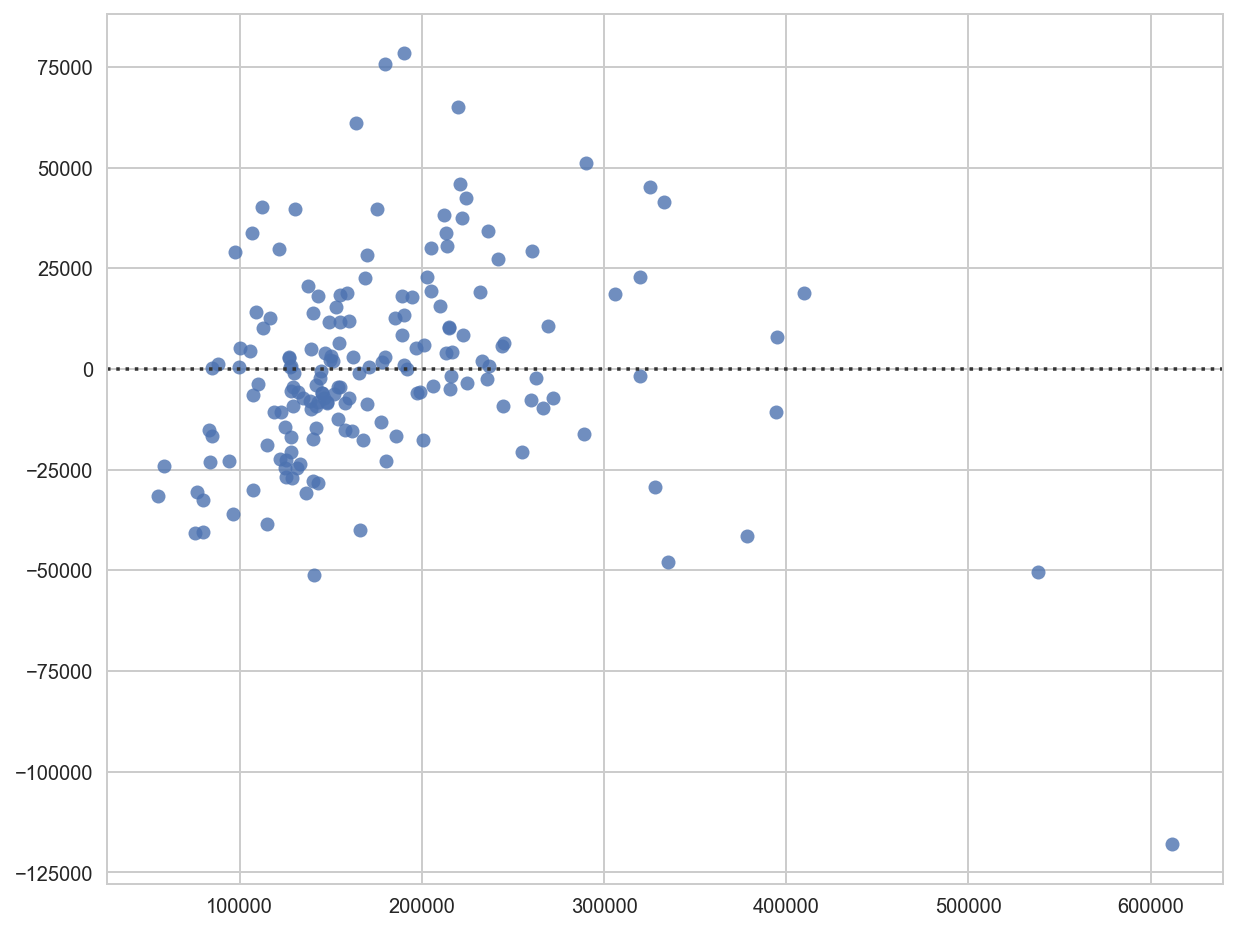

In [53]:
fig, ax =plt.subplots(figsize=(10,8))
sns.residplot(yp_test, y_pred_lasso, ax=ax)

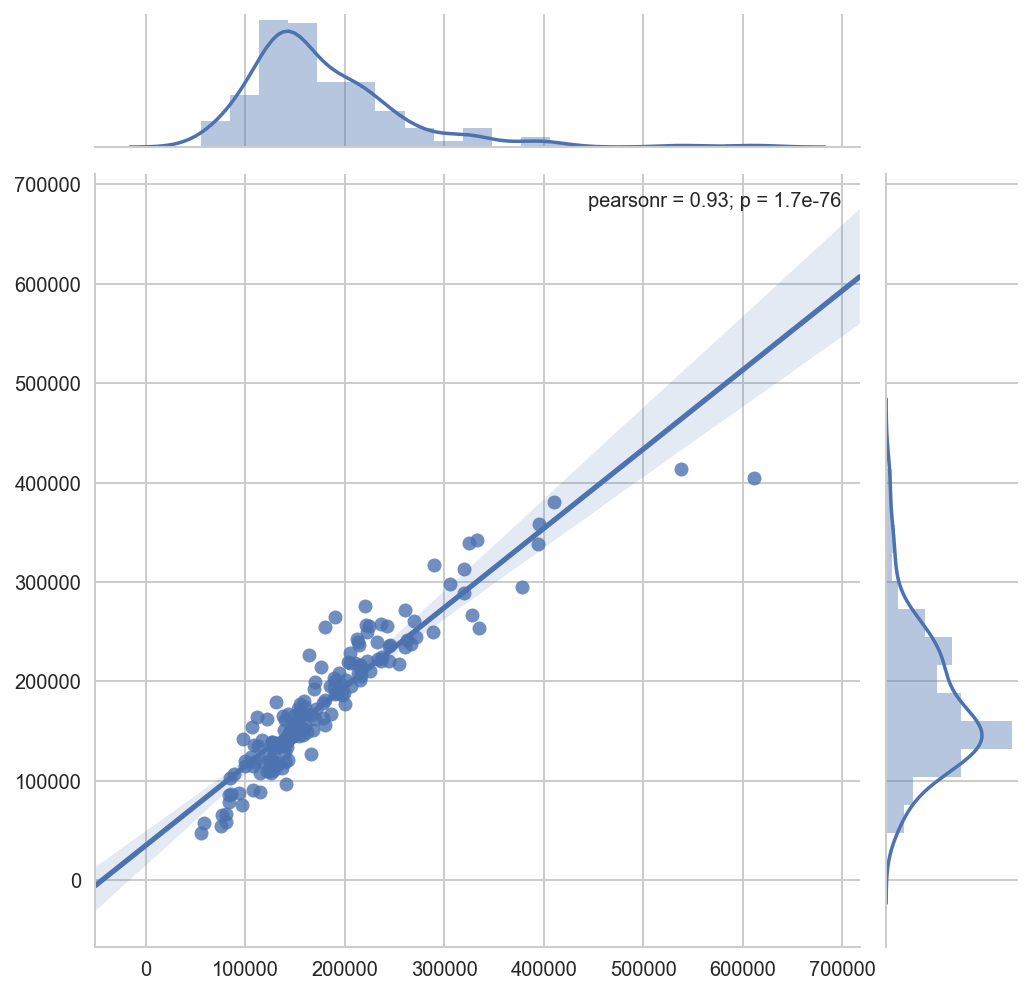

In [54]:
sns.jointplot(yp_test, y_pred_lasso, kind='reg', size=7)

In [55]:
#print X_p.columns
#print lassoregcv.coef_

coeffs = pd.DataFrame(lassoregcv.coef_, index=X_p.columns)
coeffs
coeffs.columns = ['lasso_coefs']
coeffs_abs = coeffs.abs().sort_values('lasso_coefs', ascending=False)
coeffs_abs.head(20)

lasso_coefs
GrLivArea                25037.495634
OverallQual              21213.681238
Neighborhood[T.NridgHt]   9508.391612
Neighborhood[T.NoRidge]   7753.046870
GarageCars                7102.900298
MSSubClass                6088.130601
YearBuilt                 5306.576732
SaleType[T.New]           5133.002594
Neighborhood[T.StoneBr]   5074.831827
BsmtExposure[T.Gd]        4660.281842
Condition2[T.PosN]        4294.614972
BsmtFinSF1                3639.066049
YearRemodAdd              3396.924697
OverallCond               3271.501077
BsmtFullBath              3159.697970
BsmtQual[T.Gd]            3013.403648
BsmtExposure[T.No]        2974.281395
LotArea                   2590.393248
Fireplaces                2473.540325
Neighborhood[T.Crawfor]   2441.264616

Best Predictors of SalePrice

### Cross Validation

In [56]:
#### Cross Validation ####

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics

scores1 = cross_val_score(lrt, X_p, y_p, cv=5)
sm1 = scores1.mean()
ss1 = scores1.std()

scores2 = cross_val_score(lr, X_p, y_p, cv=5)
sm2 = scores2.mean()
ss2 = scores2.std()

scores3 = cross_val_score(selector2, X_p, y_p, cv=5)
sm3 = scores3.mean()
ss3 = scores3.std()

scores4 = cross_val_score(lassoregcv, X_p, y_p, cv=5)
sm4 = scores4.mean()
ss4 = scores4.std()

print 'Non Scale Model'
print scores1
print sm1
print ss1

print 'Scale Model'
print scores2
print sm2
print ss2

print 'RFECV Model'
print scores3
print sm3
print ss3

print 'Lasso Model'
print scores4
print sm4
print ss4

### Lasso Model will be used ###
### Cross Validation with whole dataset, test + train

C:\Users\AlanKong-PC\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Non Scale Model
[ 0.88336205  0.82010278  0.7865568   0.85458378  0.68767446]
0.806455975113
0.0677083324474
Scale Model
[ 0.88336205  0.82010278  0.7865568   0.85458378  0.68767446]
0.806455975113
0.0677083324474
RFECV Model
[  8.83362053e-01  -1.89731206e+14   8.24738830e-01   8.61419723e-01
   7.43875307e-01]
-3.79462412123e+13
7.58924824245e+13
Lasso Model
[ 0.89592983  0.83405502  0.8261894   0.85071099  0.6811393 ]
0.817604906026
0.0723850342297


### Final Model used would be the lassocv model. Has the highest cross validation score.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### Prepare Data for renov features.

In [57]:
## renovatable feature, drop the Fence, PoolQC, FireplaceQu

renov_col = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 
             'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'GarageFinish'
             , 'GarageQual', 'GarageCond', 'YrSold', 'SalePrice']

renov_df = data[renov_col]


## Use back X_p - original train/test set to get y_predicted. X-p contains the full dataset for fixed features

ss = StandardScaler()
Xp_o = ss.fit_transform(X_p)

## Variance = predicted price - sale price
renov_df['variance'] = (renov_df['SalePrice'] - lassoregcv.predict(Xp_o))

import patsy

f = 'variance ~ '+' + '.join([c for c in renov_df.columns if not c == 'variance']) + ' -1'
yr, Xr1 = patsy.dmatrices(f, data=renov_df, return_type='dataframe')
yr = yr.values.ravel()

## Drop year and sale price
Xr = Xr1.drop(['YrSold', 'SalePrice'], axis = 1)

## Took out zero variance columns and drop them out.

def nearZeroVariance(X, freqCut = 95 / 5, uniqueCut = 10):
    '''
    Determine predictors with near zero or zero variance.
    Inputs:
    X: pandas data frame
    freqCut: the cutoff for the ratio of the most common value to the second most common value
    uniqueCut: the cutoff for the percentage of distinct values out of the number of total samples
    Returns a tuple containing a list of column names: (zeroVar, nzVar)
    '''

    colNames = X.columns.values.tolist()
    freqRatio = dict()
    uniquePct = dict()

    for names in colNames:
        counts = (
            (X[names])
            .value_counts()
            .sort_values(ascending = False)
            .values
            )

        if len(counts) == 1:
            freqRatio[names] = -1
            uniquePct[names] = (len(counts) / len(X[names])) * 100
            continue

        freqRatio[names] = counts[0] / counts[1]
        uniquePct[names] = (len(counts) / len(X[names])) * 100

    zeroVar = list()
    nzVar = list()
    for k in uniquePct.keys():
        if freqRatio[k] == -1:
            zeroVar.append(k)

        if uniquePct[k] < uniqueCut and freqRatio[k] > freqCut:
            nzVar.append(k)

    return(zeroVar, nzVar)

zeroVar, nzVar = nearZeroVariance(Xr)
Xr = Xr.drop(nzVar,axis=1)

print Xr.shape

## Extract test and train (using YrSold)
Xr_train = Xr[~Xr1['YrSold'].isin([2010.0])]
Xr_test = Xr[Xr1['YrSold'].isin([2010.0])]
yr_train = yr[~Xr1['YrSold'].isin([2010.0])]
yr_test = yr[Xr1['YrSold'].isin([2010.0])]


print Xr_test.shape
print Xr_train.shape

## Scale
##ss = StandardScaler()
##Xrs = ss.fit_transform(Xr_train)
##Xrts = ss.fit_transform(Xr_test)

##print Xrs.shape
##print Xrts.shape


C:\Users\AlanKong-PC\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(1450, 36)
(172, 36)
(1278, 36)


In [58]:
# y - yhat
# In general, slightly more overpredicted price, more negative variance

print len(renov_df[renov_df['variance'].values > 0].variance)
print len(renov_df[renov_df['variance'].values < 0].variance)

689
761


### Use LassoCV to fit

In [59]:
# select the best alpha with LassoCV

lassoregcv2 = LassoCV(n_alphas=10000, normalize=True , cv=7, random_state=1, n_jobs=-1, max_iter=5000)
lassoregcv2.fit(Xr_train, yr_train)
print 'alpha = ' + str(lassoregcv2.alpha_)
print lassoregcv2.get_params
print lassoregcv2.coef_

y_pred_lasso2 = lassoregcv2.predict(Xr_test)

train_score_lcv2 = lassoregcv2.score(Xr_train, yr_train)
test_score_lcv2 = lassoregcv2.score(Xr_test, yr_test)
print ''
print 'R2 score (train set) = ' + str(train_score_lcv2)
print 'R2 score (test set) = ' + str(test_score_lcv2)
print 'RMSE = ' + str(np.sqrt(mean_squared_error(yr_test, y_pred_lasso2)))

alpha = 15.9184393902
<bound method LassoCV.get_params of LassoCV(alphas=None, copy_X=True, cv=7, eps=0.001, fit_intercept=True,
    max_iter=5000, n_alphas=10000, n_jobs=-1, normalize=True,
    positive=False, precompute='auto', random_state=1, selection='cyclic',
    tol=0.0001, verbose=False)>
[ -1599.7244418     239.94908344   -977.41870159      0.           -715.64800139
     -0.             -0.          -1090.57111152      0.             -0.
      0.              0.             -0.          -3465.12345469     -0.
      0.           3294.29946938    168.8267017     944.64853152
  -2122.73772986   -277.74373582  -4367.03050453     -0.           -825.2895173
  -1649.77934232      0.           -389.17627882 -13798.88378845
 -11928.096118     2555.6820467   -2471.81248966   -143.44895713
    206.36326387     -0.             71.63669479     -0.        ]

R2 score (train set) = 0.0648459407354
R2 score (test set) = 0.131216285152
RMSE = 27530.2419116


In [60]:
#print X_p.columns
#print lassoregcv.coef_

coeffs = pd.DataFrame(lassoregcv2.coef_, index=Xr.columns)
coeffs
coeffs.columns = ['lasso_coefs']
coeffs_sort = coeffs.sort_values('lasso_coefs', ascending=False)
coeffs_sort[coeffs_sort.values != 0]

lasso_coefs
BsmtCond[T.TA]           3294.299469
GarageFinish[T.NIL]      2555.682047
BsmtFinType1[T.GLQ]       944.648532
RoofStyle[T.Hip]          239.949083
GarageQual[T.NIL]         206.363264
BsmtFinType1[T.BLQ]       168.826702
GarageCond[T.NIL]          71.636695
GarageFinish[T.Unf]      -143.448957
BsmtFinType1[T.Rec]      -277.743736
Electrical[T.SBrkr]      -389.176279
Exterior1st[T.Plywood]   -715.648001
HeatingQC[T.Gd]          -825.289517
Exterior1st[T.HdBoard]   -977.418702
Exterior2nd[T.HdBoard]  -1090.571112
RoofStyle[T.Gable]      -1599.724442
HeatingQC[T.TA]         -1649.779342
BsmtFinType1[T.LwQ]     -2122.737730
GarageFinish[T.RFn]     -2471.812490
ExterQual[T.TA]         -3465.123455
BsmtFinType1[T.Unf]     -4367.030505
KitchenQual[T.TA]      -11928.096118
KitchenQual[T.Gd]      -13798.883788

Choose highly negative or positive coef.
A negative coef means it will bring the underpredicted price closer to the True Price.
A positive coef means it will bring the overpredicted price closer to the True Price.
y - yhat negative (overpredict)
y - yhat positive (underpredict)

Will choose KitchenQual, BsmtFinType1 and ExterQual into the Dataset and train Model for SalePrice again to see the R2 different.

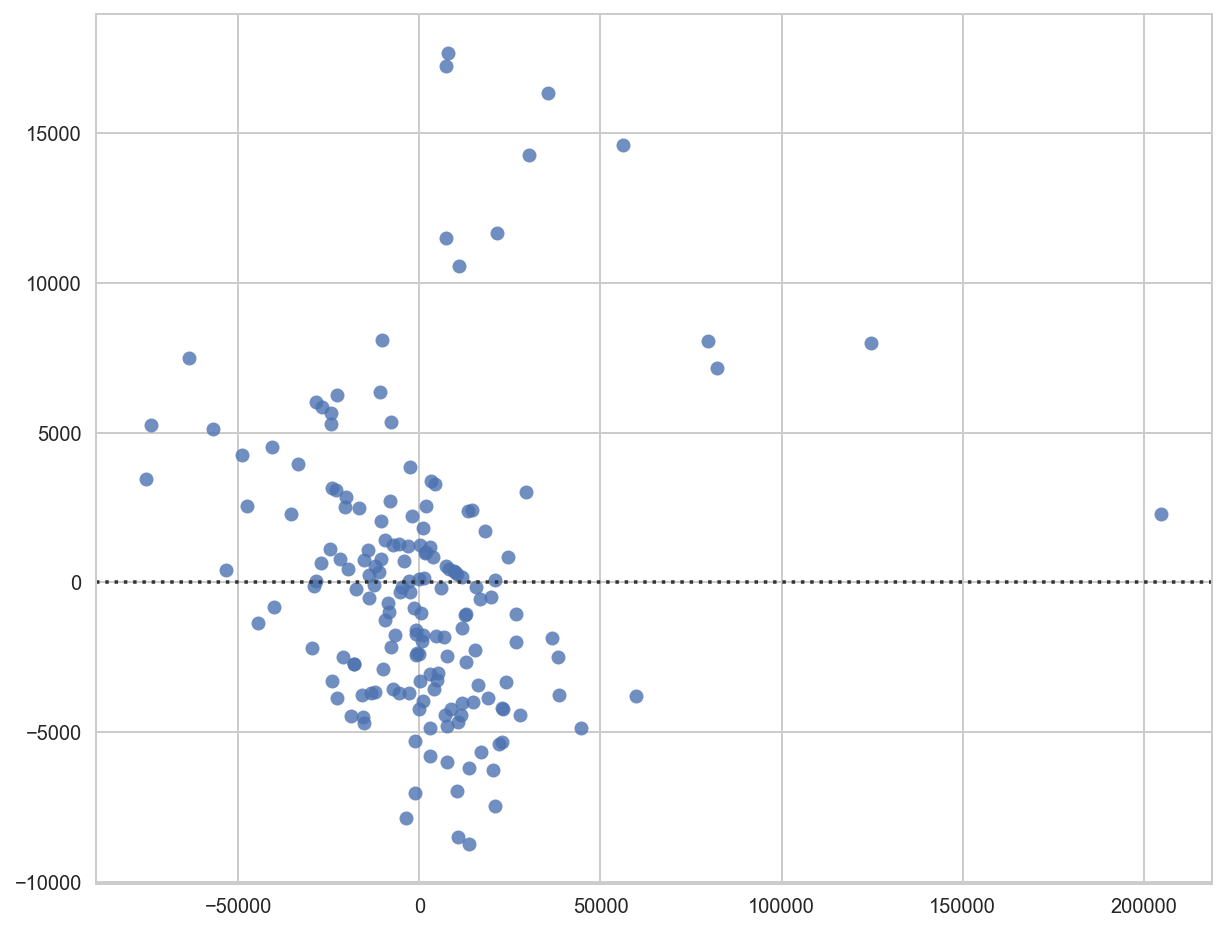

In [61]:
fig, ax =plt.subplots(figsize=(10,8))
sns.residplot(yr_test, y_pred_lasso2, ax=ax)

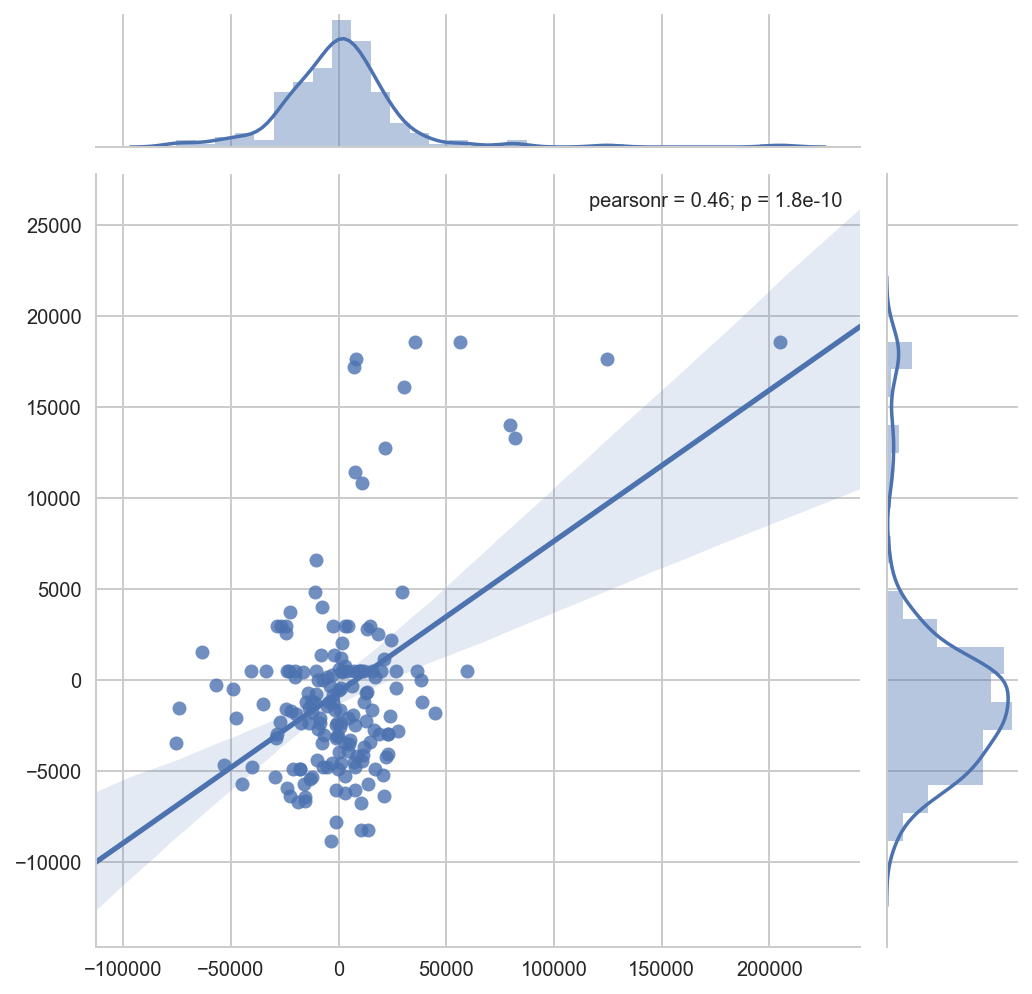

In [62]:
sns.jointplot(yr_test, y_pred_lasso2, kind='reg', size=7)

In [63]:
data['KitchenQual'].value_counts()

TA    727
Gd    586
Ex    100
Fa     37
Name: KitchenQual, dtype: int64

In [64]:
data['BsmtFinType1'].value_counts()

Unf    424
GLQ    418
ALQ    220
BLQ    147
Rec    130
LwQ     74
NIL     37
Name: BsmtFinType1, dtype: int64

In [65]:
data['ExterQual'].value_counts()

TA    899
Gd    488
Ex     52
Fa     11
Name: ExterQual, dtype: int64

In [66]:
# X_p, y_p original dataset for LassoCV model
# include All KitchenQual to see the effect on R2 from Q1 model.

Xp_new = X_p.join(data[['KitchenQual','BsmtFinType1','ExterQual']])
kq = pd.get_dummies(Xp_new, columns = ['KitchenQual','BsmtFinType1','ExterQual'])
kq = kq.drop(['KitchenQual_Fa', 'BsmtFinType1_NIL','ExterQual_Fa'], axis = 1)

In [67]:
# X_p, y_p original dataset for LassoCV model
# include All KitchenQual to see the effect on R2 from Q1 model.

## Extract test and train (using YrSold)
Xpn_train = kq[~kq['YrSold'].isin([2010.0])]
Xpn_test = kq[kq['YrSold'].isin([2010.0])]
ypn_train = y_p[~kq['YrSold'].isin([2010.0])]
ypn_test = y_p[kq['YrSold'].isin([2010.0])]

## Scale
ss = StandardScaler()
Xpns = ss.fit_transform(Xpn_train)
Xpnts = ss.transform(Xpn_test)


#from sklearn.linear_model import LassoCV
lassoregcv3 = LassoCV(n_alphas=10000, normalize=True , cv=7, random_state=1, n_jobs=-1)
lassoregcv3.fit(Xpns, ypn_train)
print 'alpha = ' + str(lassoregcv3.alpha_)
print lassoregcv3.get_params
#lassoregcv3.coef_

y_pred_lasso3 = lassoregcv3.predict(Xpnts)

train_score_lcv3 = lassoregcv3.score(Xpns, yp_train)
test_score_lcv3 = lassoregcv3.score(Xpnts, yp_test)
print ''
print 'R2 score (train set) = ' + str(train_score_lcv3)
print 'R2 score (test set) = ' + str(test_score_lcv3)
print 'RMSE = ' + str(np.sqrt(mean_squared_error(yp_test, y_pred_lasso3)))


### Linear Model From Q1
##alpha = 44.1379762046
##<bound method LassoCV.get_params of LassoCV(alphas=None, copy_X=True, cv=7, eps=0.001, fit_intercept=True,
##    max_iter=1000, n_alphas=10000, n_jobs=-1, normalize=True,
##    positive=False, precompute='auto', random_state=1, selection='cyclic',
##    tol=0.0001, verbose=False)>
##
##R2 score (train set) = 0.857378093283
##R2 score (test set) = 0.861376378961
##RMSE = 29686.4562374

alpha = 52.3142251222
<bound method LassoCV.get_params of LassoCV(alphas=None, copy_X=True, cv=7, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=10000, n_jobs=-1, normalize=True,
    positive=False, precompute='auto', random_state=1, selection='cyclic',
    tol=0.0001, verbose=False)>

R2 score (train set) = 0.863584409927
R2 score (test set) = 0.882885883946
RMSE = 27286.2818327


In [68]:
# Check effect of adding back KitchenQual + BsmtFinType1 + ExterQual columns to Model 1

coeffs = pd.DataFrame(lassoregcv3.coef_, index=kq.columns)
coeffs
coeffs.columns = ['lasso_coefs']
coeffs_sort = coeffs.sort_values('lasso_coefs', ascending=False)
coeffs_sort[coeffs_sort.values != 0]

lasso_coefs
GrLivArea                23837.786902
OverallQual              18139.139652
GarageCars                7639.212918
KitchenQual_Ex            7435.405549
Neighborhood[T.NoRidge]   7421.950753
Neighborhood[T.NridgHt]   6396.377074
BsmtExposure[T.Gd]        4912.293734
SaleType[T.New]           4181.763124
YearBuilt                 4097.660454
Neighborhood[T.StoneBr]   3956.712958
ExterQual_Ex              3549.792634
LotArea                   2764.048400
OverallCond               2675.628952
Fireplaces                2544.932886
Neighborhood[T.Crawfor]   2394.222808
YearRemodAdd              2382.736241
BsmtFullBath              2336.133635
WoodDeckSF                2118.911137
BsmtFinType1_GLQ          1990.954339
Functional[T.Typ]         1736.636866
LotConfig[T.CulDSac]      1706.388646
FullBath                  1608.848723
TotalBsmtSF               1549.354423
BsmtFinSF1                1436.314574
Condition1[T.Norm]        1313.671183
MasVnrArea                1039.927794
ScreenPorch                881.334143
Neighborhood[T.Somerst]    777.905724
Neighborhood[T.Veenker]     91.698607
SaleType[T.Con]             17.546154
O1stFlrSF                    6.270003
Functional[T.Sev]          -86.578394
Condition1[T.Feedr]       -175.834588
KitchenQual_TA            -398.509972
BldgType[T.Duplex]        -445.523442
Neighborhood[T.OldTown]   -610.998179
KitchenAbvGr              -622.875433
LotShape[T.IR3]           -882.265238
Neighborhood[T.Edwards]  -1054.683469
BsmtFinType1_Unf         -1097.238310
MSZoning[RM]             -1538.626153
BsmtExposure[T.No]       -2286.162804
ExterQual_TA             -2890.814167
Condition2[T.PosN]       -4561.731428
MSSubClass               -5744.282488

*** By including KitchenQual + BsmtFinType1 + ExterQual feature into Model 1, R2 value became better than before for LassoCV model.***

If these features is renovated, these are the cost increase in SalePrice
1. KitchenQual_Ex = $7435.405549

2. ExterQual_Ex = $3549.792634

3. BsmtFinType1_GLQ = $1990.954339

Evaluate the effect in dollars of the renovate-able features.

How would your company use this second model and its coefficients to determine whether they should buy a property or not?

Explain how the company can use the two models you have built to determine if they can make money.

Investigate how much of the variance in price remaining is explained by these features.

Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

Our Company can use Model 2 to identify which renovatable features has the most effect on the variance (y - yhat)
y = SalePrice actual
yhat = SalePrice predicted
Model 2 tells you what renov feature to include into Model 1 such that it improves your Model 1 R2 score (closer to True Price)

If the new Model with the renov feature included shows up with very high lasso_coef after fit, it means this renov feature will increase the SalePrice for every increase of in value of that renov features. The coef of that value will give you gain in SalePrice for the renovation done. For example, if you were to renov your Kitchen and increase KitchenQual to Ex, your increase in SalePrice is $7435. Depending on the cost of the renovation, you can earn the profit from this increase in SalePrice.

I would not trust the Model as the fit is very poor due to the disperse variance values, R2 score of the Model 2 is 0.13. There is very little correlation between the renov features and the variance.


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [69]:
test3 = data

In [70]:
test3['SaleCondition'].value_counts() 

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [71]:
## Baseline of each class
test3['SaleCondition'].value_counts() / test3['SaleCondition'].value_counts().sum()

Normal     0.823448
Partial    0.086207
Abnorml    0.066207
Family     0.013793
Alloca     0.007586
AdjLand    0.002759
Name: SaleCondition, dtype: float64

In [72]:
## Baseline Accuracy
test3.SaleCondition = test3.SaleCondition.map(lambda x: '1' if x == 'Abnorml' else '0')

In [73]:
test3['SaleCondition'].value_counts() / test3['SaleCondition'].value_counts().sum()

0    0.933793
1    0.066207
Name: SaleCondition, dtype: float64

In [74]:
test3.SaleCondition = test3.SaleCondition.map(lambda x: int(x))

In [75]:
test3=test3.rename(columns = {'1stFlrSF':'O1stFlrSF', '2ndFlrSF':'O2ndFlrSF' , '3SsnPorch':'O3SsnPorch'})

In [76]:
# patsy to prepare the data

f= 'SaleCondition ~ '+' + '.join([c for c in test3.columns if not c == 'SaleCondition']) + ' -1'
y, X = patsy.dmatrices(f, data=test3, return_type='dataframe')
y = y.values.ravel()



print X.shape
print y.shape
X = X.rename(columns=lambda x: x.replace('[', ''))
X = X.rename(columns=lambda x: x.replace(']', ''))
X.head()

(1450, 257)
(1450L,)


MSZoningFV  MSZoningRH  MSZoningRL  MSZoningRM  StreetT.Pave  AlleyT.NIL  \
0         0.0         0.0         1.0         0.0           1.0         1.0   
1         0.0         0.0         1.0         0.0           1.0         1.0   
2         0.0         0.0         1.0         0.0           1.0         1.0   
3         0.0         0.0         1.0         0.0           1.0         1.0   
4         0.0         0.0         1.0         0.0           1.0         1.0   

   AlleyT.Pave  LotShapeT.IR2  LotShapeT.IR3  LotShapeT.Reg    ...      \
0          0.0            0.0            0.0            1.0    ...       
1          0.0            0.0            0.0            1.0    ...       
2          0.0            0.0            0.0            0.0    ...       
3          0.0            0.0            0.0            0.0    ...       
4          0.0            0.0            0.0            0.0    ...       

   WoodDeckSF  OpenPorchSF  EnclosedPorch  O3SsnPorch  ScreenPorch  PoolArea  \
0         0.0         61.0            0.0         0.0          0.0       0.0   
1       298.0          0.0            0.0         0.0          0.0       0.0   
2         0.0         42.0            0.0         0.0          0.0       0.0   
3         0.0         35.0          272.0         0.0          0.0       0.0   
4       192.0         84.0            0.0         0.0          0.0       0.0   

   MiscVal  MoSold  YrSold  SalePrice  
0      0.0     2.0  2008.0   208500.0  
1      0.0     5.0  2007.0   181500.0  
2      0.0     9.0  2008.0   223500.0  
3      0.0     2.0  2006.0   140000.0  
4      0.0    12.0  2008.0   250000.0  

[5 rows x 257 columns]

In [77]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split

seed = 12

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=seed)
# Total number of Abnorml = 96
print ('no of Abnorml in y_train = ' + str(y_train.sum()))
print ('no of Abnorml in y_test = '+ str(y_test.sum()))

no of Abnorml in y_train = 67.0
no of Abnorml in y_test = 29.0


In [79]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

In [80]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':1
}

num_rounds = 15

In [81]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [82]:
pd.crosstab(
    pd.Series(y_test, name ='Actual'),
    pd.Series(y_test_preds, name = 'Predicted'),
    margins = True
)

Predicted    0  1  All
Actual                
0.0        405  1  406
1.0         29  0   29
All        434  1  435

Totally out without scaling the weight.

In [83]:
print('accuracy = ' + format(accuracy_score(y_test, y_test_preds)))
print('precision = ' + format(precision_score(y_test, y_test_preds)))
print('recall = ' + format(recall_score(y_test, y_test_preds)))

accuracy = 0.931034482759
precision = 0.0
recall = 0.0


### Add weights to y_train for the 2 class

In [84]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 9

dtrain = xgb.DMatrix(X_train, label = y_train, weight=weights)
dtest = xgb.DMatrix(X_test)

In [85]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [86]:
pd.crosstab(
    pd.Series(y_test, name ='Actual'),
    pd.Series(y_test_preds, name = 'Predicted'),
    margins = True
)

Predicted    0   1  All
Actual                 
0.0        361  45  406
1.0         17  12   29
All        378  57  435

In [87]:
print('accuracy = ' + format(accuracy_score(y_test, y_test_preds)))
print('precision = ' + format(precision_score(y_test, y_test_preds)))
print('recall = ' + format(recall_score(y_test, y_test_preds)))

accuracy = 0.857471264368
precision = 0.210526315789
recall = 0.413793103448


### set scale_pos_weight

In [88]:
# scale_pos_weight, [default=1]
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative cases) / sum(positive cases) See Parameters Tuning for more discussion. 
# Also see Higgs Kaggle competition demo for examples: R, py1, py2, py3

In [89]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

In [90]:
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [91]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted    0    1  All
Actual                  
0.0        292  114  406
1.0          9   20   29
All        301  134  435

In [92]:
print('accuracy = ' + format(accuracy_score(y_test, y_test_preds)))
print('precision = ' + format(precision_score(y_test, y_test_preds)))
print('recall = ' + format(recall_score(y_test, y_test_preds)))

accuracy = 0.71724137931
precision = 0.149253731343
recall = 0.689655172414


In [93]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_test_preds)

             precision    recall  f1-score   support

        0.0       0.97      0.72      0.83       406
        1.0       0.15      0.69      0.25        29

avg / total       0.92      0.72      0.79       435



In [94]:
numeric = test3.select_dtypes(exclude=['object']).columns
print len(numeric)
numeric = numeric.drop('SaleCondition')
cat = [c for c in test3.columns if c not in numeric]
test4 = test3[cat]

38


In [95]:
# patsy to prepare the data

f= 'SaleCondition ~ '+' + '.join([c for c in test3.columns if not c == 'SaleCondition']) + ' -1'
y, X = patsy.dmatrices(f, data=test3, return_type='dataframe')
y = y.values.ravel()



print X.shape
print y.shape
X = X.rename(columns=lambda x: x.replace('[', ''))
X = X.rename(columns=lambda x: x.replace(']', ''))
X.head()

(1450, 257)
(1450L,)


MSZoningFV  MSZoningRH  MSZoningRL  MSZoningRM  StreetT.Pave  AlleyT.NIL  \
0         0.0         0.0         1.0         0.0           1.0         1.0   
1         0.0         0.0         1.0         0.0           1.0         1.0   
2         0.0         0.0         1.0         0.0           1.0         1.0   
3         0.0         0.0         1.0         0.0           1.0         1.0   
4         0.0         0.0         1.0         0.0           1.0         1.0   

   AlleyT.Pave  LotShapeT.IR2  LotShapeT.IR3  LotShapeT.Reg    ...      \
0          0.0            0.0            0.0            1.0    ...       
1          0.0            0.0            0.0            1.0    ...       
2          0.0            0.0            0.0            0.0    ...       
3          0.0            0.0            0.0            0.0    ...       
4          0.0            0.0            0.0            0.0    ...       

   WoodDeckSF  OpenPorchSF  EnclosedPorch  O3SsnPorch  ScreenPorch  PoolArea  \
0         0.0         61.0            0.0         0.0          0.0       0.0   
1       298.0          0.0            0.0         0.0          0.0       0.0   
2         0.0         42.0            0.0         0.0          0.0       0.0   
3         0.0         35.0          272.0         0.0          0.0       0.0   
4       192.0         84.0            0.0         0.0          0.0       0.0   

   MiscVal  MoSold  YrSold  SalePrice  
0      0.0     2.0  2008.0   208500.0  
1      0.0     5.0  2007.0   181500.0  
2      0.0     9.0  2008.0   223500.0  
3      0.0     2.0  2006.0   140000.0  
4      0.0    12.0  2008.0   250000.0  

[5 rows x 257 columns]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=seed)
# Total number of Abnorml = 96
print ('no of Abnorml in y_train = ' + str(y_train.sum()))
print ('no of Abnorml in y_test = '+ str(y_test.sum()))

no of Abnorml in y_train = 67.0
no of Abnorml in y_test = 29.0


In [97]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.4,
}

num_rounds = 12

In [110]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [111]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted    0    1  All
Actual                  
0.0        274  132  406
1.0          8   21   29
All        282  153  435

In [100]:
print('accuracy = ' + format(accuracy_score(y_test, y_test_preds)))
print('precision = ' + format(precision_score(y_test, y_test_preds)))
print('recall = ' + format(recall_score(y_test, y_test_preds)))

accuracy = 0.404597701149
precision = 0.0950704225352
recall = 0.931034482759


In [101]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_test_preds)

             precision    recall  f1-score   support

        0.0       0.99      0.37      0.54       406
        1.0       0.10      0.93      0.17        29

avg / total       0.93      0.40      0.51       435

